In [1]:
# Imports

import os
import pickle
import gc

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import wilcoxon
from scipy.stats import pearsonr
from scipy.stats import permutation_test
from processing_session_trajectory import *


In [2]:
path_to_data_folder = '/home/david/MyLocalData/Maud/'
pattern_of_MOU_Folders = os.path.join(path_to_data_folder, "MOU*")

mice_list: list[str] = ["MOU3867","MOU4551","MOU4562","MOU4560","MOU4623","MOU4624","MOU4552","MOU4563","MOU4561","MOU4692",
                              "MOU4695","MOU4698","MOU4703","MOU4175","MOU4988","MOU4964","MOU4965","MOU4986","MOU5007", "MOU5130",
                              "MOU5140","MOU5142","MOU5143","MOU5144","MOU5145","MOU5148","MOU5149", "MOU5158"]

session_list = {}
for mouse in mice_list:
    mouse_folder = os.path.join(path_to_data_folder,mouse)
    session_list[mouse] = sorted([name for name in os.listdir(mouse_folder)
                           if os.path.isdir(os.path.join(mouse_folder, name))
                           and name.startswith('MOU')])
    nb_sessions = len(session_list[mouse])
    # print(f'Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions')

#MOU4993 ? No effect of CNO but fluo at histology

In [3]:
# Define groups
UL_Gq_D1_DLS: list[str] = ["MOU4551","MOU4988","MOU5130","MOU5140","MOU5142","MOU5143"]
UL_Gq_D2_DLS: list[str] = ["MOU4562","MOU4560","MOU5144","MOU5148","MOU5149","MOU5143"]
UL_Gq_D1_DMS: list[str] = ["MOU4624","MOU4552","MOU4703","MOU3867","MOU4986","MOU5007","MOU4623"]
UL_Gq_D2_DMS: list[str] = ["MOU4563","MOU4561","MOU4695","MOU4698","MOU4692","MOU4964","MOU4965","MOU4175","MOU5145"]

groups = {
    "D1 DLS": UL_Gq_D1_DLS,
    "D2 DLS": UL_Gq_D2_DLS,
    "D1 DMS": UL_Gq_D1_DMS,
    "D2 DMS": UL_Gq_D2_DMS
}

# Define lists according to first CNO congruence
batch_starting_incongruent: list[str] = ['MOU3867','MOU4175','MOU4551','MOU4552','MOU4560','MOU4561','MOU4562','MOU4563','MOU4623','MOU4624','MOU4692',
                                         'MOU4695','MOU4698','MOU4703', 'MOU5130','MOU5140','MOU5144','MOU5158']
batch_starting_congruent: list[str] = ['MOU4988','MOU4964','MOU4965','MOU4986','MOU5007','MOU5142','MOU5143','MOU5145','MOU5148','MOU5149']

bias_to_rewarded_direction: list[str] = ['incongruent','congruent','mixed']

# Define CNO sessions indices
session_cno_indices = {
    "cno_first": 20,
    "cno_second": 30,
    "cno_third": 42
}

# Colormaps dictionary
colormaps = {
    "D1 DLS": "Greens",
    "D2 DLS": "Oranges",
    "D1 DMS": "Blues",
    "D2 DMS": "RdPu"
}

In [4]:
# Define dictionaries to store pickle results per session and per mouse
positions_cm_dict = {}
X_positions_dict = {}
Y_positions_dict = {}
total_distances = {}
average_speeds = {}
distances_dict = {}
speeds_dict = {}
angular_speeds_dict = {}
all_epochs_dict = {}
traject_time_dict = {}
run_around_tower_results_dict = {}
runs_around_tower_dict = {}
trapezes_coordinates_dict = {}
towers_coordinates_dict = {}
runs_between_towers_dict = {}
exploratory_runs_dict = {}
time_border_dict = {}
time_interior_dict = {}
time_trapeze_dict = {}
distance_border_dict = {}
distance_interior_dict = {}
distance_trapeze_dict = {}
ratio_time_trapeze_over_border = {}
ratio_distance_trapeze_over_border = {}
time_trapeze_minus_border = {}
distance_trapeze_minus_border = {}

# Loop to process each mouse
for mouse in mice_list:
    
    # Initialize subdictionaries for each mouse
    positions_cm_dict[mouse] = {}
    X_positions_dict[mouse] = {}
    Y_positions_dict[mouse] = {}
    total_distances[mouse] = {}
    average_speeds[mouse] = {}
    distances_dict[mouse] = {}
    speeds_dict[mouse] = {}
    angular_speeds_dict[mouse] = {}
    all_epochs_dict[mouse] = {}
    traject_time_dict[mouse] = {}
    run_around_tower_results_dict[mouse] = {}
    runs_around_tower_dict[mouse] = {}
    trapezes_coordinates_dict[mouse] = {}
    towers_coordinates_dict[mouse] = {}
    runs_between_towers_dict[mouse] = {}
    exploratory_runs_dict[mouse] = {}
    time_border_dict[mouse] = {}
    time_interior_dict[mouse] = {}
    time_trapeze_dict[mouse] = {}
    distance_border_dict[mouse] = {}
    distance_interior_dict[mouse] = {}
    distance_trapeze_dict[mouse] = {}
    ratio_time_trapeze_over_border[mouse] = {}
    ratio_distance_trapeze_over_border[mouse] = {}
    time_trapeze_minus_border[mouse] = {}
    distance_trapeze_minus_border[mouse] = {}

    for session_index, session_name in enumerate(session_list[mouse]):
        
        output_pickle_filepath = os.path.join(path_to_data_folder, mouse, session_name, f"{session_name}_basic_processing_output.pickle")

        if not os.path.exists(output_pickle_filepath):
            print(f"Erreur : le fichier {output_pickle_filepath} n'existe pas.")
            continue
        elif os.path.getsize(output_pickle_filepath) == 0:
            print(f"Erreur : le fichier {output_pickle_filepath} est vide.")
            continue

        # Loading data from the pickle
        try:
            with open(output_pickle_filepath, 'rb') as f:
                data = pickle.load(f)
        except EOFError:
            print(f"Erreur de lecture : le fichier {output_pickle_filepath} semble être corrompu.")
            continue

        # Data extraction
        positions_cm = data['positions']
        X_positions_cm = data['positions'][0]
        Y_positions_cm = data['positions'][1]
        average_speed = data['average_speed']
        distances = data['distances']
        speeds = data['speeds']
        angular_speeds = data['angular_speeds']
        all_epochs = data['all_epochs']
        traject_time = data['timeofframes']
        run_around_tower_results = data['run_around_tower_sessionresult']
        runs_around_tower = all_epochs['run_around_tower']
        runs_between_towers = all_epochs['run_between_towers']
        exploratory_runs = all_epochs['exploratory_run']
        trapezes_coordinates = data['all_trapezes_coordinates_cm']
        towers_coordinates = data['towers_coordinates_cm']
        time_border = data['time_in_zones']['border']
        time_interior = data['time_in_zones']['interior']
        time_trapeze = data['time_in_zones']['trapeze']
        distance_border = data['distance_in_zones']['border']
        distance_interior = data['distance_in_zones']['interior']
        distance_trapeze = data['distance_in_zones']['trapeze']

        # Calculation of total distance in meters
        total_distance = np.sum(distances) / 100

        # Storing in full dictionaries using session index
        positions_cm_dict[mouse][session_index] = positions_cm
        X_positions_dict[mouse][session_index] = X_positions_cm
        Y_positions_dict[mouse][session_index] = Y_positions_cm
        total_distances[mouse][session_index] = total_distance
        average_speeds[mouse][session_index] = average_speed
        distances_dict[mouse][session_index] = distances
        speeds_dict[mouse][session_index] = speeds
        angular_speeds_dict[mouse][session_index] = angular_speeds
        all_epochs_dict[mouse][session_index] = all_epochs
        traject_time_dict[mouse][session_index] = traject_time
        run_around_tower_results_dict[mouse][session_index] = run_around_tower_results
        runs_around_tower_dict[mouse][session_index] = runs_around_tower
        trapezes_coordinates_dict[mouse][session_index] = trapezes_coordinates
        towers_coordinates_dict[mouse][session_index] = towers_coordinates
        runs_between_towers_dict[mouse][session_index] = runs_between_towers
        exploratory_runs_dict[mouse][session_index] = exploratory_runs
        time_border_dict[mouse][session_index] = time_border
        time_interior_dict[mouse][session_index] = time_interior
        time_trapeze_dict[mouse][session_index] = time_trapeze
        distance_border_dict[mouse][session_index] = distance_border
        distance_interior_dict[mouse][session_index] = distance_interior
        distance_trapeze_dict[mouse][session_index] = distance_trapeze

        if time_border == 0:
            ratio_time_trapeze_over_border[mouse][session_index] = 0
        else:
            ratio_time_trapeze_over_border[mouse][session_index] = time_trapeze/time_border

        if distance_border == 0:
            ratio_distance_trapeze_over_border[mouse][session_index] = 0
        else:
            ratio_distance_trapeze_over_border[mouse][session_index] = distance_trapeze/distance_border

        time_trapeze_minus_border[mouse][session_index] = time_trapeze - time_border
        distance_trapeze_minus_border[mouse][session_index] = distance_trapeze - distance_border


# print(time_zones_dict['MOU3867'][25]['border']) # Example of how to call a dictionnary


## Basic metrics and runs around towers (QT) analysis

#### Compare metrics between groups and before/after CNO injection. Also possible to use this to study learning.

D2 DMS Incongruent (Totale distance (m)) - Statistique de Wilcoxon: 1.0, p-value: 0.0078
D2 DMS Incongruent (Average speed (cm/s)) - Statistique de Wilcoxon: 1.0, p-value: 0.0078


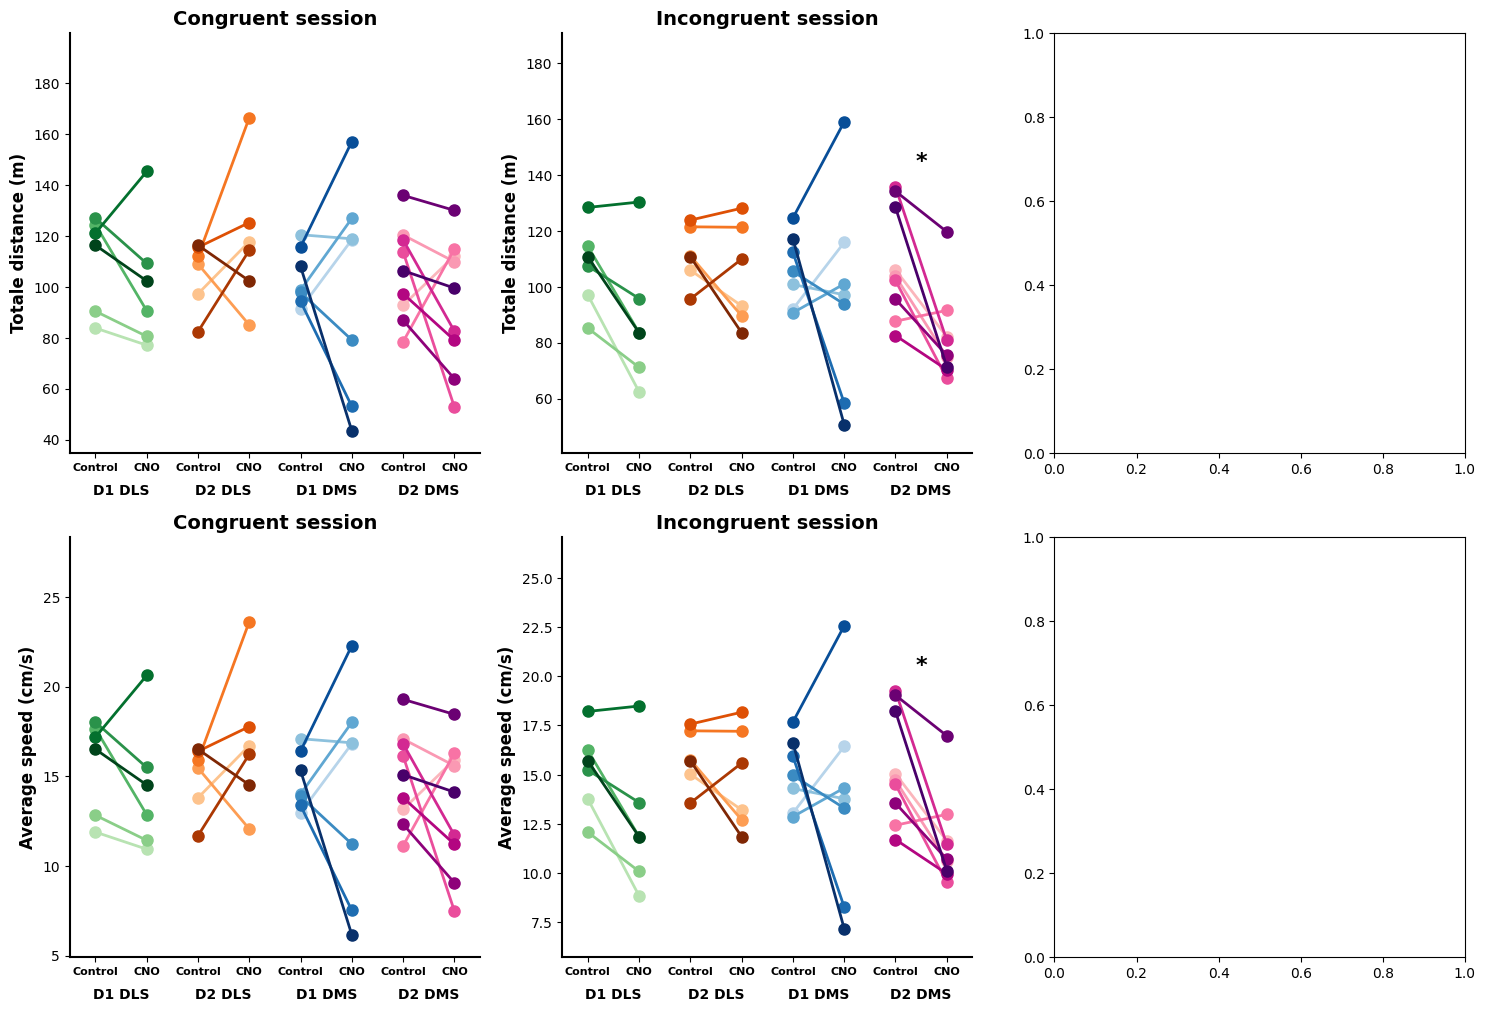

In [5]:
# Function to compare a metric between groups before and after CNO injection

def plot_metric_comparison_by_group(ax, metric_dict, metric_name, groups, set_title=True, bias_direction="congruent"):
    """
    Compares a metric before and after CNO injection for each group, with improved display.
    
    :param ax: Matplotlib axis on which to draw the graph.
    :param metric_dict: Dictionary of metrics for each mouse.
    :param metric_name: Name of the metric to display on the Y axis.
    :param groups: Mouse group dictionary (group name → list of mice).
    :param bias_direction: "congruent", "incongruent" ou "mixed".
    """

    # Definition of CNO sessions and control based on condition
    if bias_direction == "Mixed":
        session_cno_selected = {mouse: session_cno_indices["cno_third"] for mouse in mice_list}
    else:
        session_cno_selected = {
            mouse: session_cno_indices["cno_second"] if mouse in batch_starting_incongruent 
            else session_cno_indices["cno_first"]
            for mouse in mice_list
        } if bias_direction == "Congruent" else {
            mouse: session_cno_indices["cno_first"] if mouse in batch_starting_incongruent 
            else session_cno_indices["cno_second"]
            for mouse in mice_list
        }

    session_control_selected = {mouse: idx - 4 for mouse, idx in session_cno_selected.items()}

    tick_positions = []
    session_labels = []
    group_annotations = []
    
    all_data = []
    wilcoxon_results = {}

    # Loop through each group to retrieve the data and plot the points
    for i, (group_name, group_mice) in enumerate(groups.items()):
        group_control_data = []
        group_cno_data = []
        
        cmap = plt.get_cmap(colormaps.get(group_name))  # Group specific colormap
        colors = cmap(np.linspace(0.3, 1, len(group_mice)))  # Color gradient for group mice
        
        for j, mouse in enumerate(group_mice):
            if mouse in metric_dict:
                if session_control_selected[mouse] in metric_dict[mouse] and session_cno_selected[mouse] in metric_dict[mouse]:
                    before = metric_dict[mouse][session_control_selected[mouse]]
                    after = metric_dict[mouse][session_cno_selected[mouse]]

                    group_control_data.append(before)
                    group_cno_data.append(after)
                    all_data.extend([before, after])

                    # Position on the X axis
                    control_position = i * 2
                    cno_position = i * 2 + 1

                    # Drawing lines and points
                    ax.plot([control_position, cno_position], [before, after], color=colors[j], linewidth=2, linestyle='-', marker='o', markersize=8)

        # 🔬 Wilcoxon test for D1 DMS and D2 DMS (only those groups for now because of the N)
        if group_name in ["D1 DMS", "D2 DMS"] and len(group_control_data) > 0 and len(group_cno_data) > 0:
            stat, p_value = wilcoxon(group_control_data, group_cno_data)
            wilcoxon_results[group_name] = {"statistic": stat, "p_value": p_value}

            # 🌟 Display a star (*) if p-value ≤ 0.05
            if p_value <= 0.05:
                max_value = max(max(group_control_data), max(group_cno_data))
                ax.text((control_position + cno_position) / 2, max_value * 1.05, "*", 
                        fontsize=16, fontweight='bold', ha='center', color='black')

        # Added positions and labels for the X axis
        tick_positions.extend([i * 2, i * 2 + 1])
        session_labels.extend(["Control", "CNO"])

        # Add group annotation
        group_annotations.append((i * 2 + 0.5, group_name))

    # Axis configuration
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(session_labels, fontsize=10, fontweight='bold')

    # Displaying group names below pairs of points
    for pos, group_name in group_annotations:
        ax.annotate(group_name, xy=(pos, -0.1), xycoords=('data', 'axes fraction'), ha='center', fontsize=10, fontweight='bold')

    if set_title:
        ax.set_title(f"{bias_direction} session", fontsize=14, fontweight='bold')
    ax.set_ylabel(metric_name, fontsize=12, fontweight='bold')

    # Automatic definition of ylim with a 20% margin
    if all_data:
        ax.set_ylim(min(all_data)*0.8, max(all_data) * 1.2)

    ax.set_xlim(-0.5, len(groups) * 2 - 0.5)

    # Removed grids for a cleaner display
    ax.grid(False)

    # Customizing the axes
    ax.tick_params(axis='y', which='major', labelsize=10)
    ax.tick_params(axis='x', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    # Displaying results in the console
    for group, result in wilcoxon_results.items():
        if result['p_value'] <= 0.05:
            print(f"{group} {bias_direction} ({metric_name}) - Statistique de Wilcoxon: {result['statistic']}, p-value: {result['p_value']:.4f}")

# Example of use
fig, axs = plt.subplots(2,3,figsize=(18, 12))
plot_metric_comparison_by_group(axs[0,0], total_distances, "Totale distance (m)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], total_distances, "Totale distance (m)", groups, bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[0,2], total_distances, "Totale distance (m)", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], average_speeds, "Average speed (cm/s)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], average_speeds, "Average speed (cm/s)", groups, bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[1,2], average_speeds, "Average speed (cm/s)", groups, bias_direction="Mixed")

plt.show()


In [6]:
# Retrieve distance, time, mean speed, max speed
# Initialize counters and lists for run analysis

total_time_QT_dict = {}
total_distance_QT_dict = {}
meanspeed_QT_dict = {}
maxspeed_QT_dict = {}

for mouse in mice_list:
    total_time_QT_dict[mouse] = {}
    total_distance_QT_dict[mouse] = {}
    meanspeed_QT_dict[mouse] = {}
    maxspeed_QT_dict[mouse] = {}

    for session_index, session_name in enumerate(session_list[mouse]):

            total_time_QT = 0
            total_distance_QT = 0
            speed_QT = []

            for run in runs_around_tower_dict[mouse][session_index]:
                start_index, end_index = run[0][0], run[0][1]
                run_duration = traject_time_dict[mouse][session_index][end_index] - traject_time_dict[mouse][session_index][start_index]
                distance_ran = np.sum(distances_dict[mouse][session_index][start_index:end_index])

                # Accumulate metrics
                speed_QT.append(distance_ran / run_duration)
                total_time_QT += run_duration
                total_distance_QT += distance_ran

            # Store results for this session in the dictionaries
            meanspeed_QT_dict[mouse][session_index] = np.mean(speed_QT)
            maxspeed_QT_dict[mouse][session_index] = np.max(speed_QT)
            total_time_QT_dict[mouse][session_index] = round(total_time_QT, 2)
            total_distance_QT_dict[mouse][session_index] = round(total_distance_QT, 2)

D2 DMS Incongruent (Total distance doing QT (cm)) - Statistique de Wilcoxon: 4.0, p-value: 0.0273


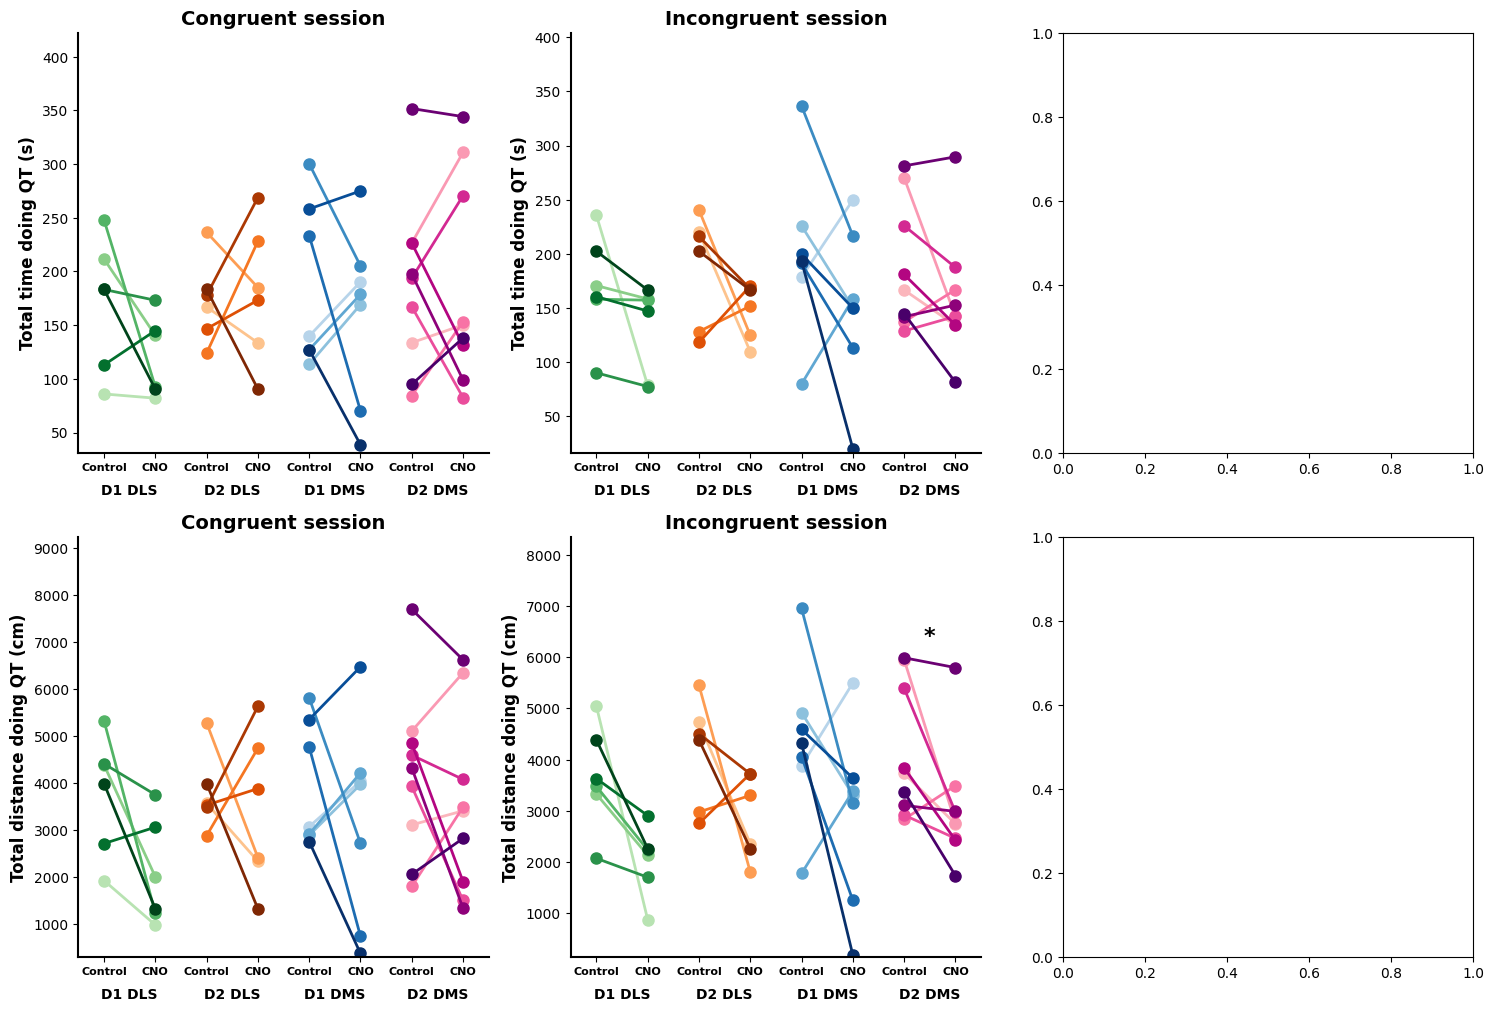

In [7]:
# Plot time/distance of runs around towers with plot_metric_comparison_by_group

fig, axs = plt.subplots(2,3,figsize=(18, 12))
plot_metric_comparison_by_group(axs[0,0], total_time_QT_dict, "Total time doing QT (s)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], total_time_QT_dict, "Total time doing QT (s)", groups, bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[0,2], total_time_QT_dict, "Total time doing QT (s)", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], total_distance_QT_dict, "Total distance doing QT (cm)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], total_distance_QT_dict, "Total distance doing QT (cm)", groups, bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[1,2], total_distance_QT_dict, "Total distance doing QT (cm)", groups, bias_direction="Mixed")

plt.show()

D2 DMS Congruent (Mean speed of QT (cm/s)) - Statistique de Wilcoxon: 2.0, p-value: 0.0117
D2 DMS Incongruent (Mean speed of QT (cm/s)) - Statistique de Wilcoxon: 0.0, p-value: 0.0039
D2 DMS Incongruent (Max speed of QT (cm/s)) - Statistique de Wilcoxon: 2.0, p-value: 0.0117


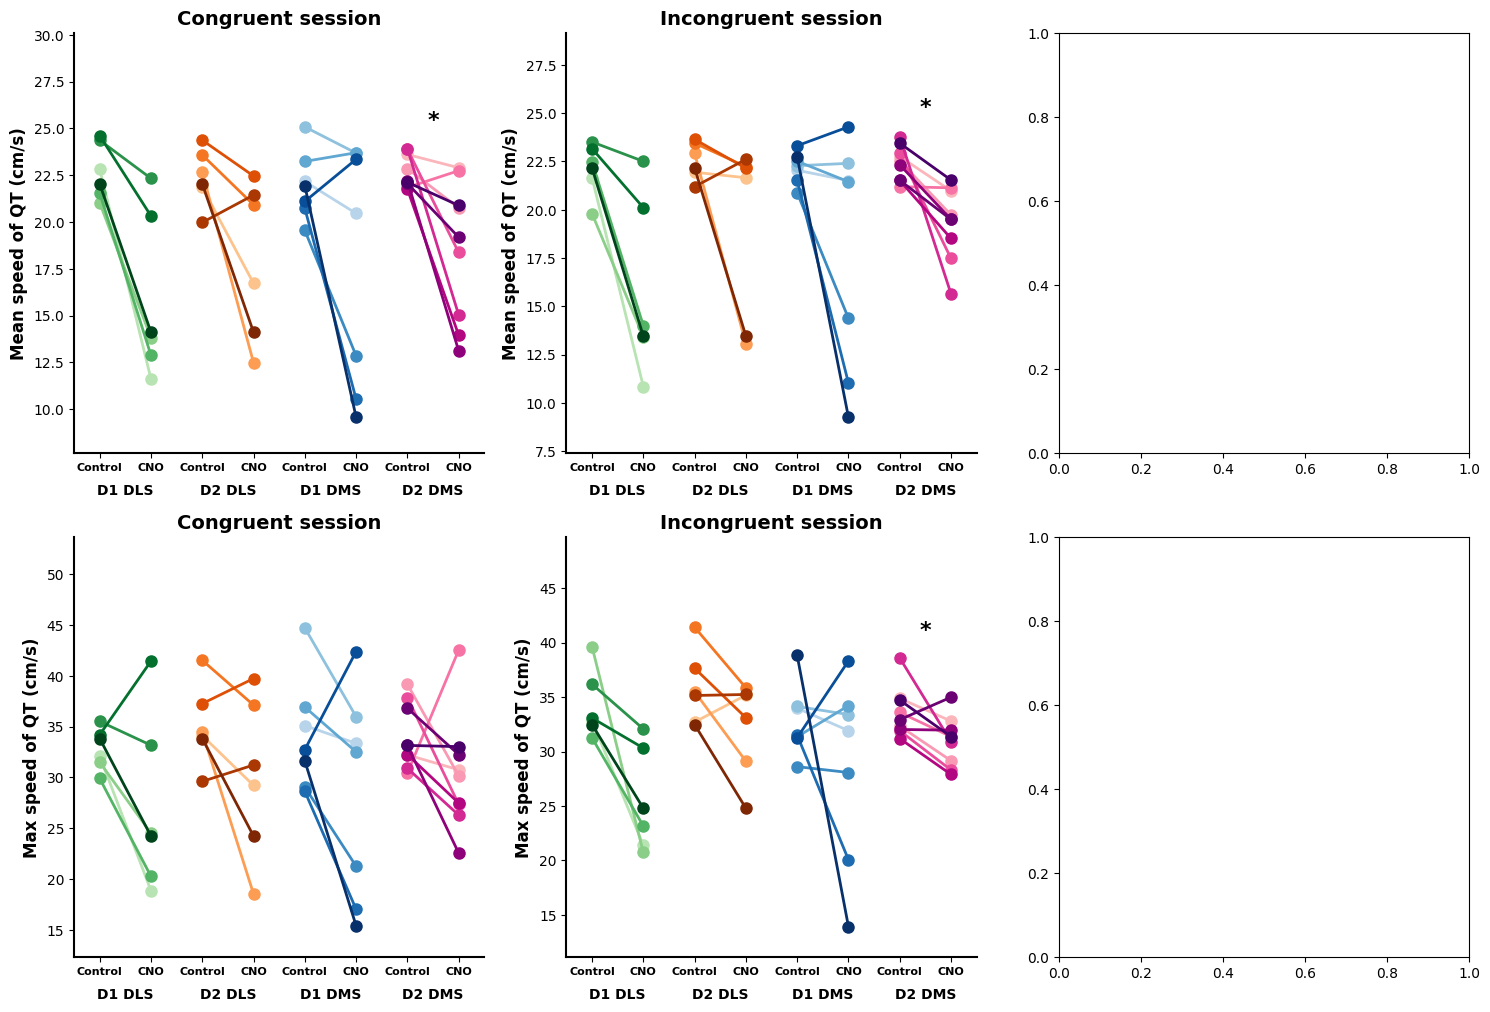

In [8]:
# Plot speeds of runs around towers with plot_metric_comparison_by_group

fig, axs = plt.subplots(2,3,figsize=(18, 12))
plot_metric_comparison_by_group(axs[0,0], meanspeed_QT_dict, "Mean speed of QT (cm/s)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], meanspeed_QT_dict, "Mean speed of QT (cm/s)", groups, bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[0,2], meanspeed_QT_dict, "Mean speed of QT (cm/s)", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], maxspeed_QT_dict, "Max speed of QT (cm/s)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], maxspeed_QT_dict, "Max speed of QT (cm/s)", groups, bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[1,2], maxspeed_QT_dict, "Max speed of QT (cm/s)", groups, bias_direction="Mixed")

plt.show()

In [9]:
# Dictionnaries of CW/CCW/rewarded/unrewarded/total runs around towers

total_QT_dict = {}
total_QT_rewarded_dict = {}
total_QT_unrewarded_dict = {}
total_CW_dict = {}
total_CCW_dict = {}
ratio_CW_CCW_dict = {}
percentage_rewarded_dict = {}

for mouse in mice_list:
    
    total_QT_dict[mouse] = {}
    total_QT_rewarded_dict[mouse] = {}
    total_QT_unrewarded_dict[mouse] = {}
    total_CW_dict[mouse] = {}
    total_CCW_dict[mouse] = {}
    ratio_CW_CCW_dict[mouse] = {}
    percentage_rewarded_dict[mouse] = {}

    for session_index, session_name in enumerate(session_list[mouse]):

        total_CW_rewarded = run_around_tower_results_dict[mouse][session_index]['All']['rewarded_CW']
        total_CCW_rewarded = run_around_tower_results_dict[mouse][session_index]['All']['rewarded_CCW']
        total_CW = run_around_tower_results_dict[mouse][session_index]['All']['total_CW']
        total_CCW = run_around_tower_results_dict[mouse][session_index]['All']['total_CCW']
        
        total_QT = total_CW + total_CCW
        total_QT_rewarded = total_CW_rewarded + total_CCW_rewarded
        total_QT_unrewarded = total_QT - total_QT_rewarded
        ratio_CW_CCW = (total_CW - total_CCW) / total_QT
        percentage_rewarded = round((total_QT_rewarded / total_QT) * 100, 2)

        total_QT_dict[mouse][session_index] = total_QT
        total_QT_rewarded_dict[mouse][session_index] = total_QT_rewarded
        total_QT_unrewarded_dict[mouse][session_index] = total_QT_unrewarded
        total_CW_dict[mouse][session_index] = total_CW
        total_CCW_dict[mouse][session_index] = total_CCW
        ratio_CW_CCW_dict[mouse][session_index] = ratio_CW_CCW
        if session_index == 0:
            percentage_rewarded_dict[mouse][session_index] = 0
        else:
            percentage_rewarded_dict[mouse][session_index] = percentage_rewarded

D2 DMS Incongruent (Total nb of QT) - Statistique de Wilcoxon: 3.0, p-value: 0.0195
D1 DMS Incongruent (Total nb of rewarded QT) - Statistique de Wilcoxon: 2.0, p-value: 0.0469
D2 DMS Incongruent (Total nb of unrewarded QT) - Statistique de Wilcoxon: 5.5, p-value: 0.0469


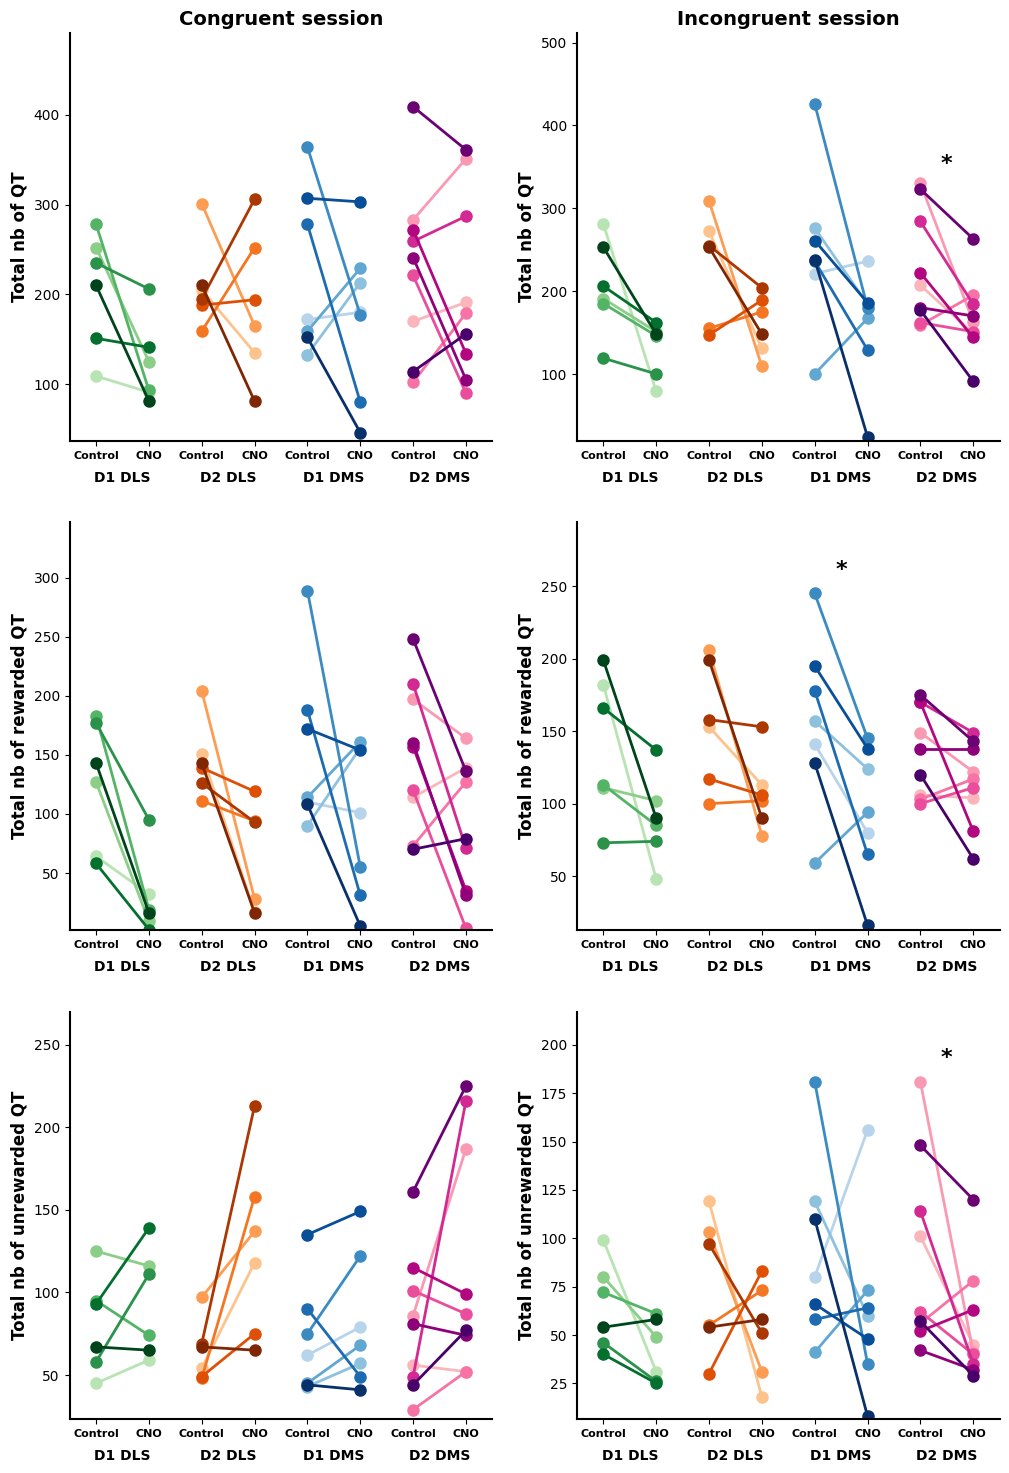

In [13]:
# Plot number of QT/rewarded/unrewarded with plot_metric_comparison_by_group

fig, axs = plt.subplots(3,2,figsize=(12, 18))
plot_metric_comparison_by_group(axs[0,0], total_QT_dict, "Total nb of QT", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], total_QT_dict, "Total nb of QT", groups, bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[0,2], total_QT_dict, "Total nb of QT", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], total_QT_rewarded_dict, "Total nb of rewarded QT", groups, set_title=False, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], total_QT_rewarded_dict, "Total nb of rewarded QT", groups, set_title=False,bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[1,2], total_QT_rewarded_dict, "Total nb of rewarded QT", groups, set_title=False,bias_direction="Mixed")

plot_metric_comparison_by_group(axs[2,0], total_QT_unrewarded_dict, "Total nb of unrewarded QT", groups, set_title=False,bias_direction="Congruent")
plot_metric_comparison_by_group(axs[2,1], total_QT_unrewarded_dict, "Total nb of unrewarded QT", groups, set_title=False,bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[2,2], total_QT_unrewarded_dict, "Total nb of unrewarded QT", groups, set_title=False,bias_direction="Mixed")

plt.show()

D1 DMS Incongruent (Total nb of CW QT) - Statistique de Wilcoxon: 1.0, p-value: 0.0312
D2 DMS Congruent (Total nb of CCW QT) - Statistique de Wilcoxon: 3.0, p-value: 0.0195
D2 DMS Congruent (Ratio (CW-CCW)/(CW+CCW)) - Statistique de Wilcoxon: 5.0, p-value: 0.0391
D2 DMS Congruent (Success %age) - Statistique de Wilcoxon: 2.0, p-value: 0.0117


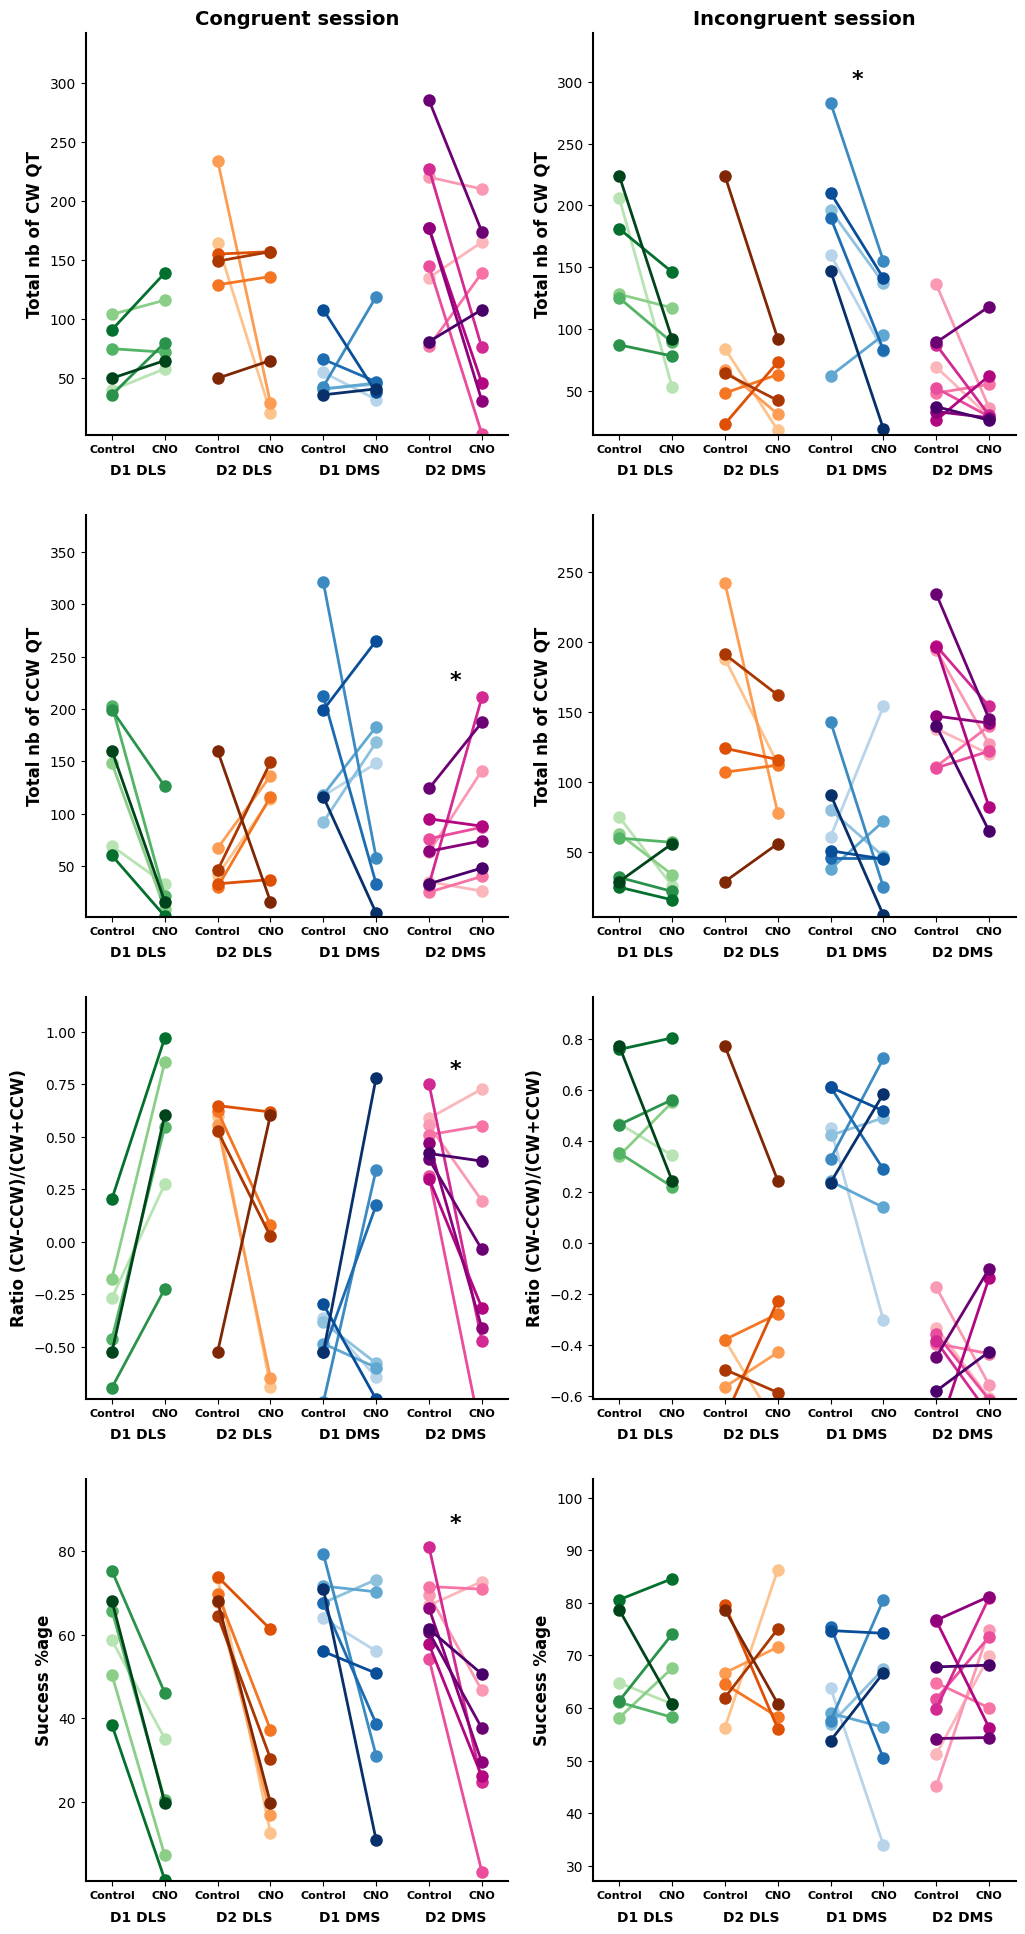

In [14]:
# Plot CW/CCW/ratio/%age of success with plot_metric_comparison_by_group

fig, axs = plt.subplots(4,2,figsize=(12, 24))
plot_metric_comparison_by_group(axs[0,0], total_CW_dict, "Total nb of CW QT", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], total_CW_dict, "Total nb of CW QT", groups, bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[0,2], total_CW_dict, "Total nb of CW QT", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], total_CCW_dict, "Total nb of CCW QT", groups, set_title=False, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], total_CCW_dict, "Total nb of CCW QT", groups, set_title=False,bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[1,2], total_CCW_dict, "Total nb of CCW QT", groups, set_title=False,bias_direction="Mixed")

plot_metric_comparison_by_group(axs[2,0], ratio_CW_CCW_dict, "Ratio (CW-CCW)/(CW+CCW)", groups, set_title=False,bias_direction="Congruent")
plot_metric_comparison_by_group(axs[2,1], ratio_CW_CCW_dict, "Ratio (CW-CCW)/(CW+CCW)", groups, set_title=False,bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[2,2], ratio_CW_CCW_dict, "Ratio (CW-CCW)/(CW+CCW)", groups, set_title=False,bias_direction="Mixed")

plot_metric_comparison_by_group(axs[3,0], percentage_rewarded_dict, "Success %age", groups, set_title=False,bias_direction="Congruent")
plot_metric_comparison_by_group(axs[3,1], percentage_rewarded_dict, "Success %age", groups, set_title=False,bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[3,2], percentage_rewarded_dict, "Success %age", groups, set_title=False,bias_direction="Mixed")

plt.show()

In [15]:
# Dictionary to store rewarded directions per session and per mouse
rewarded_direction_per_session = {}

# Browse each mouse in the mouse list
for mouse in mice_list:
    rewarded_direction_per_session[mouse] = {}  # Initialize the subdictionary for each mouse
    
    # Browse each session of this mouse
    for session_index, session_name in enumerate(session_list[mouse]):
        # Build the path to the CSV file
        csv_file_path = os.path.join(path_to_data_folder, mouse, session_name, f"{session_name}_sessionparam.csv")
        
        # Read the CSV file to get the potentialRewardedDirections column
        try:
            session_data = pd.read_csv(csv_file_path)
            rewarded_directions = session_data["potentialRewardedDirections"].iloc[0]
            
            # Decoding the rewarded direction
            if rewarded_directions == "[90]":
                direction = "CCW"
            elif rewarded_directions == "[270]":
                direction = "CW"
            else:
                direction = "both"
            
            # Add this information to the dictionary
            rewarded_direction_per_session[mouse][session_index] = direction

        except FileNotFoundError:
            print(f"Fichier {csv_file_path} non trouvé.")
        except Exception as e:
            print(f"Erreur lors de la lecture de {csv_file_path}: {e}")

In [16]:
# Dictionary to store percentage of success (turns in rewarded direction)

success_percentage_dict = {}

for mouse in mice_list:
    success_percentage_dict[mouse] = {}

    # Browse each mouse session
    for session_index, session_name in enumerate(session_list[mouse]):
        # Recover the rewarded management of the session
        rewarded_direction = rewarded_direction_per_session[mouse].get(session_index, "both")
        
        # Retrieve results for CW and CCW
        total_CW = run_around_tower_results_dict[mouse][session_index]['All']['total_CW']
        total_CCW = run_around_tower_results_dict[mouse][session_index]['All']['total_CCW']
        
        # Calculate the percentages for CW and CCW
        if total_CW + total_CCW > 0:  # Avoid division by zero
            percentage_CW = round((total_CW / (total_CW + total_CCW)) * 100, 2)
            percentage_CCW = round((total_CCW / (total_CW + total_CCW)) * 100, 2)
        else:
            percentage_CW = percentage_CCW = 0  # If no run, success percentage is 0
            
        # Select the percentage based on the direction rewarded
        if rewarded_direction == "both":
            success_percentage = percentage_rewarded_dict[mouse][session_index]
        elif rewarded_direction == "CW":
            success_percentage = percentage_CW
        elif rewarded_direction == "CCW":
            success_percentage = percentage_CCW
        else:
            print(f"No rewarded direction defined for session {session_index}")
            success_percentage = 0  # Default case if an unexpected value is present

        # Add to dictionary
        success_percentage_dict[mouse][session_index] = success_percentage

## Runs between towers (BT) analysis

#### Compare BT metrics between groups and before/after CNO injection

In [17]:
# Dictionaries for storing the results of angular velocities of runs between towers
angular_speeds_BT = {}
median_angular_speed_BT = {}

# Loop for each animal
for mouse in mice_list:
    # Initializing dictionaries for the animal
    angular_speeds_BT[mouse] = {}
    median_angular_speed_BT[mouse] = {}

    # Loop for each session
    for session_index, session_name in enumerate(session_list[mouse]):
        
        # Initialize a list to store all angular velocities for runs between towers in this session
        session_angular_speeds = []
        
        # Extraction of runs between towers
        runs_between_towers = runs_between_towers_dict[mouse][session_index]
        
        # Loop for each run between towers
        for run in runs_between_towers:

            # Extracting the start and end indices of the run
            start_idx, end_idx = run[0]  # Indexes to extract data

            # Extraction of trajectory coordinates and time for the run
            X_run = X_positions_dict[mouse][session_index][start_idx:end_idx]
            Y_run = Y_positions_dict[mouse][session_index][start_idx:end_idx]
            time_run = traject_time_dict[mouse][session_index][start_idx:end_idx]

            # Verify that the extracted data is valid
            if len(X_run) > 1 and len(Y_run) > 1 and len(time_run) > 1:
                # Calculation of distances, speeds and angular velocities
                distances, speeds, angular_speeds = compute_distance_speed_angular_speed(
                    [X_run, Y_run], time_run
                )
                # Add angular velocities of runs to the session list
                session_angular_speeds.extend(angular_speeds)
            else:
                print(f"Run invalide pour la souris {mouse}, session {session_name}, indices ({start_idx}, {end_idx}).")

        # Storing session angular velocities in the dictionary
        angular_speeds_BT[mouse][session_index] = session_angular_speeds
        
        # Calculating the median angular velocities for this session
        if session_angular_speeds:  # Check if there are angular velocities to avoid errors
            median_angular_speed_BT[mouse][session_index] = np.nanmedian(session_angular_speeds)
        else:
            median_angular_speed_BT[mouse][session_index] = None  # If no angular velocity, median not calculable

D1 DMS Congruent (Median angular speed of BT) - Statistique de Wilcoxon: 1.0, p-value: 0.0312
D2 DMS Congruent (Median angular speed of BT) - Statistique de Wilcoxon: 1.0, p-value: 0.0078
D2 DMS Incongruent (Median angular speed of BT) - Statistique de Wilcoxon: 2.0, p-value: 0.0117


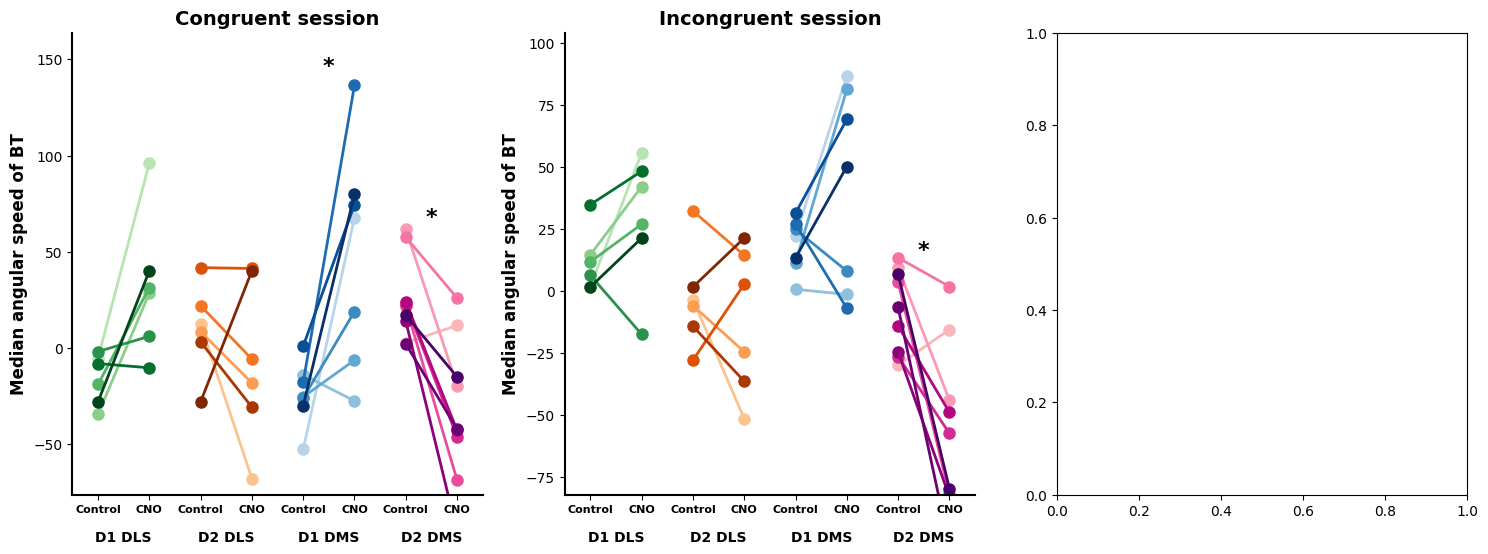

In [18]:
# Plot angular speed of BT with plot_metric_comparison_by_group

fig, axs = plt.subplots(1,3,figsize=(18, 6))
plot_metric_comparison_by_group(axs[0], median_angular_speed_BT, "Median angular speed of BT", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1], median_angular_speed_BT, "Median angular speed of BT", groups, bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[2], median_angular_speed_BT, "Median angular speed of BT", groups, bias_direction="Mixed")

plt.show()

In [19]:
# Retrieve distance, time, mean speed, max speed of BT
# Initialize counters and lists for run analysis

total_time_BT_dict = {}
total_distance_BT_dict = {}
meanspeed_BT_dict = {}
maxspeed_BT_dict = {}

for mouse in mice_list:
    total_time_BT_dict[mouse] = {}
    total_distance_BT_dict[mouse] = {}
    meanspeed_BT_dict[mouse] = {}
    maxspeed_BT_dict[mouse] = {}

    for session_index, session_name in enumerate(session_list[mouse]):

        total_time_BT = 0
        total_distance_BT = 0
        meanspeed_BT = []
        maxspeed_BT = []

        for run in runs_between_towers_dict[mouse][session_index]:
            start_index, end_index = run[0][0], run[0][1]
            run_X_position = X_positions_dict[mouse][session_index][start_index:end_index + 1]
            run_Y_position = Y_positions_dict[mouse][session_index][start_index:end_index + 1]
            run_duration = traject_time_dict[mouse][session_index][end_index] - traject_time_dict[mouse][session_index][start_index]
            distance_ran = np.sum(distances_dict[mouse][session_index][start_index:end_index])

            # Accumulate metrics
            total_time_BT += run_duration
            total_distance_BT += distance_ran
            meanspeed_BT.append(distance_ran / run_duration)
            maxspeed_BT.append(np.max(speeds_dict[mouse][session_index][start_index:end_index]))

        # Store results for this session in the dictionaries
        total_time_BT_dict[mouse][session_index] = total_time_BT
        total_distance_BT_dict[mouse][session_index] = total_distance_BT
        meanspeed_BT_dict[mouse][session_index] = np.mean(meanspeed_BT)
        maxspeed_BT_dict[mouse][session_index] = np.max(maxspeed_BT)

D2 DMS Incongruent (Total distance of BT (m)) - Statistique de Wilcoxon: 5.0, p-value: 0.0391


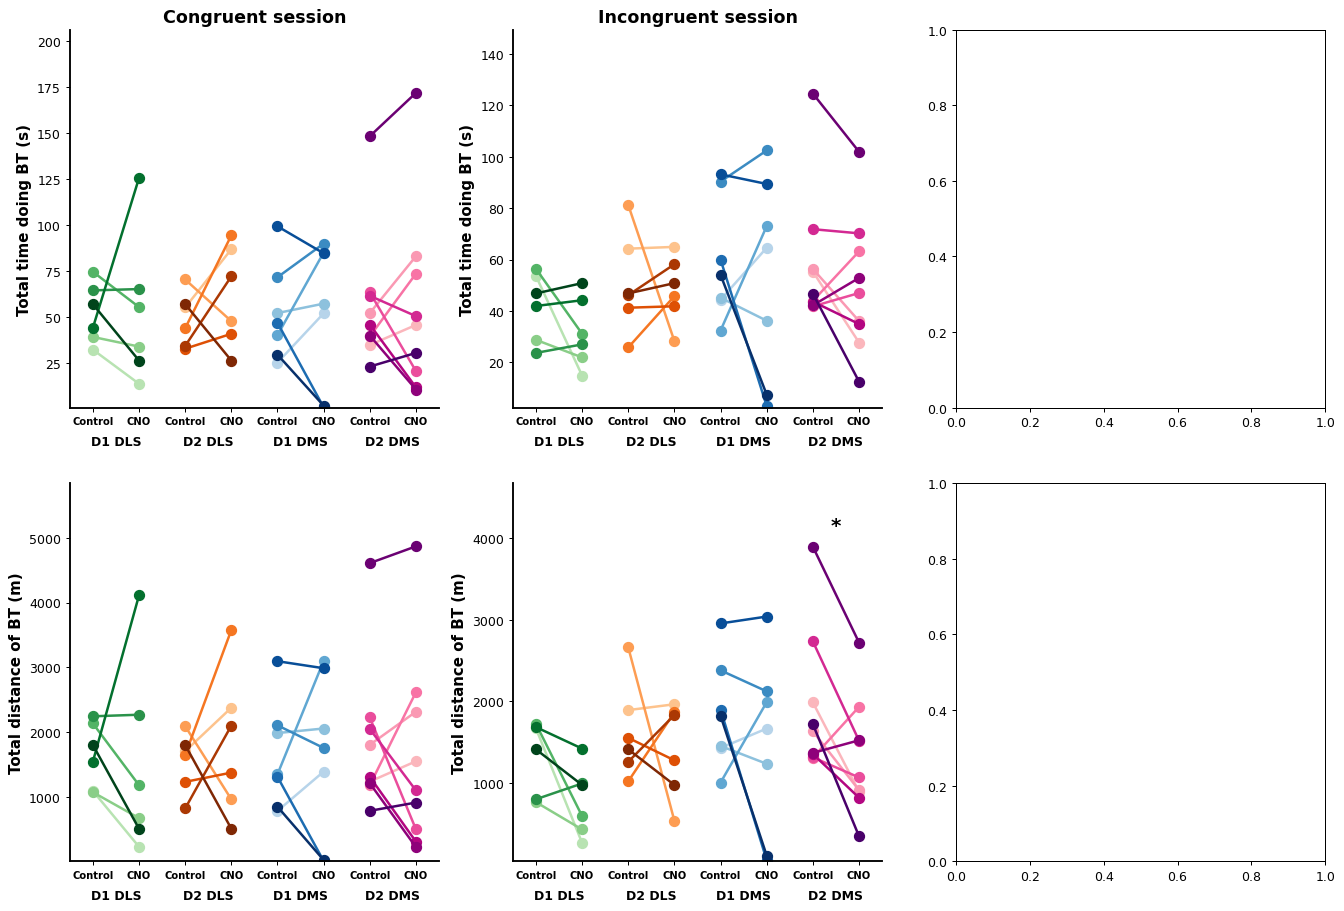

In [20]:
# Plot time/distance of BT with plot_metric_comparison_by_group

fig, axs = plt.subplots(2,3,figsize=(18, 12), dpi=90)

plot_metric_comparison_by_group(axs[0,0], total_time_BT_dict, "Total time doing BT (s)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], total_time_BT_dict, "Total time doing BT (s)", groups, bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[0,2], total_time_BT_dict, "Total time doing BT (s)", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], total_distance_BT_dict, "Total distance of BT (m)", groups, set_title=False,bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], total_distance_BT_dict, "Total distance of BT (m)", groups, set_title=False,bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[1,2], total_distance_BT_dict, "Total distance of BT (m)", groups, set_title=False,bias_direction="Mixed")

plt.show()

D2 DMS Congruent (Mean speed BT (cm/s)) - Statistique de Wilcoxon: 5.0, p-value: 0.0391
D2 DMS Incongruent (Mean speed BT (cm/s)) - Statistique de Wilcoxon: 1.0, p-value: 0.0078
D2 DMS Congruent (Max speed BT (cm/s)) - Statistique de Wilcoxon: 5.0, p-value: 0.0391


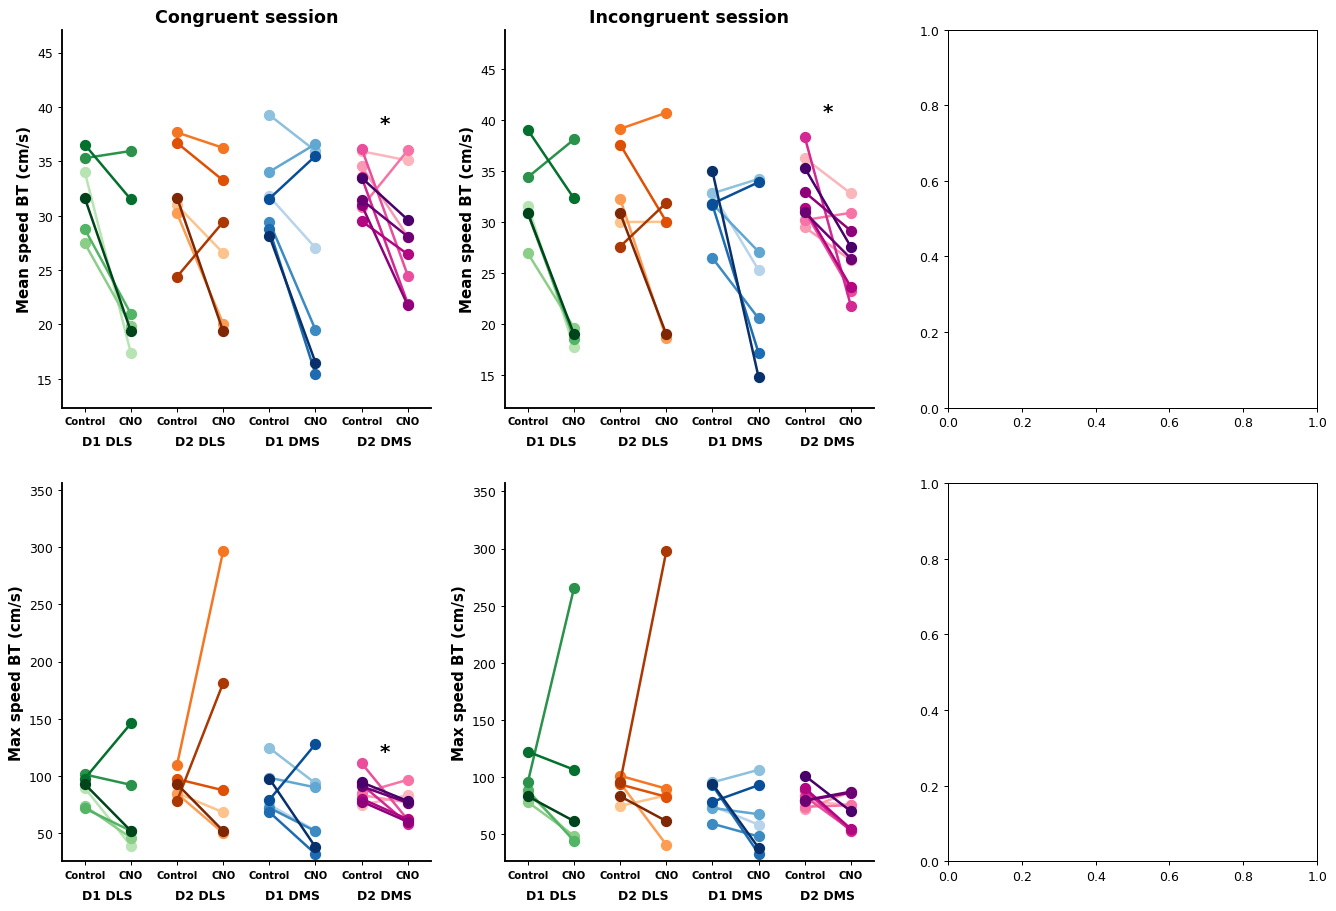

In [21]:
# Plot speeds (mean/max) of BT with plot_metric_comparison_by_group

fig, axs = plt.subplots(2,3,figsize=(18, 12), dpi=90)

plot_metric_comparison_by_group(axs[0,0], meanspeed_BT_dict, "Mean speed BT (cm/s)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], meanspeed_BT_dict, "Mean speed BT (cm/s)", groups, bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[0,2], meanspeed_BT_dict, "Mean speed BT (cm/s)", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], maxspeed_BT_dict, "Max speed BT (cm/s)", groups, set_title=False, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], maxspeed_BT_dict, "Max speed BT (cm/s)", groups, set_title=False,bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[1,2], maxspeed_BT_dict, "Max speed BT (cm/s)", groups, set_title=False,bias_direction="Mixed")

plt.show()

## Exploratory runs (ER) analysis

#### Compare ER metrics between groups and before/after CNO injection

In [22]:
# Retrieve distance, time, mean speed, max speed of exploratory runs
# Initialize counters and lists for run analysis

total_time_ER_dict = {}
total_distance_ER_dict = {}
meanspeed_ER_dict = {}
maxspeed_ER_dict = {}

for mouse in mice_list:

    total_time_ER_dict[mouse] = {}
    total_distance_ER_dict[mouse] = {}
    meanspeed_ER_dict[mouse] = {}
    maxspeed_ER_dict[mouse] = {}

    for session_index, session_name in enumerate(session_list[mouse]):

        total_time_ER = 0
        total_distance_ER = 0
        meanspeed_ER = []
        maxspeed_ER = []

        for run in exploratory_runs_dict[mouse][session_index]:
            start_index, end_index = run[0][0], run[0][1]
            run_X_position = X_positions_dict[mouse][session_index][start_index:end_index + 1]
            run_Y_position = Y_positions_dict[mouse][session_index][start_index:end_index + 1]
            run_duration = traject_time_dict[mouse][session_index][end_index] - traject_time_dict[mouse][session_index][start_index]
            distance_ran = np.sum(distances_dict[mouse][session_index][start_index:end_index])

            # Accumulate metrics
            total_time_ER += run_duration
            total_distance_ER += distance_ran
            meanspeed_ER.append(distance_ran / run_duration)
            maxspeed_ER.append(np.max(speeds_dict[mouse][session_index][start_index:end_index]))

        # Store results for this session in the dictionaries
        total_time_ER_dict[mouse][session_index] = total_time_ER
        total_distance_ER_dict[mouse][session_index] = total_distance_ER
        meanspeed_ER_dict[mouse][session_index] = np.mean(meanspeed_ER)
        maxspeed_ER_dict[mouse][session_index] = np.max(maxspeed_ER)

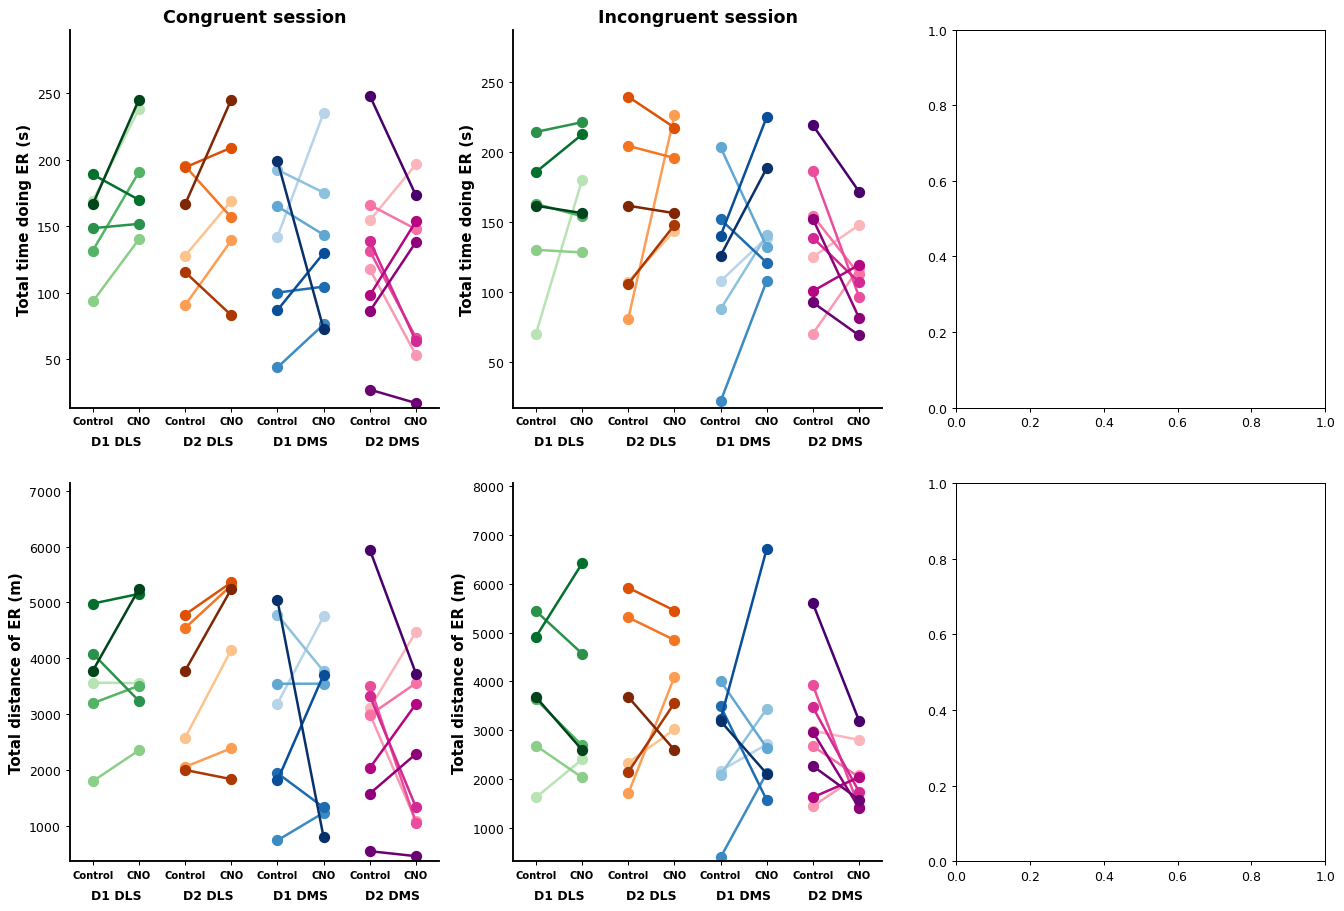

In [23]:
# Plot time/distance of ER with plot_metric_comparison_by_group

fig, axs = plt.subplots(2,3,figsize=(18, 12), dpi=90)

plot_metric_comparison_by_group(axs[0,0], total_time_ER_dict, "Total time doing ER (s)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], total_time_ER_dict, "Total time doing ER (s)", groups, bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[0,2], total_time_ER_dict, "Total time doing ER (s)", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], total_distance_ER_dict, "Total distance of ER (m)", groups, set_title=False,bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], total_distance_ER_dict, "Total distance of ER (m)", groups, set_title=False,bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[1,2], total_distance_ER_dict, "Total distance of ER (m)", groups, set_title=False,bias_direction="Mixed")

plt.show()

D2 DMS Incongruent (Mean speed ER (cm/s)) - Statistique de Wilcoxon: 3.0, p-value: 0.0195


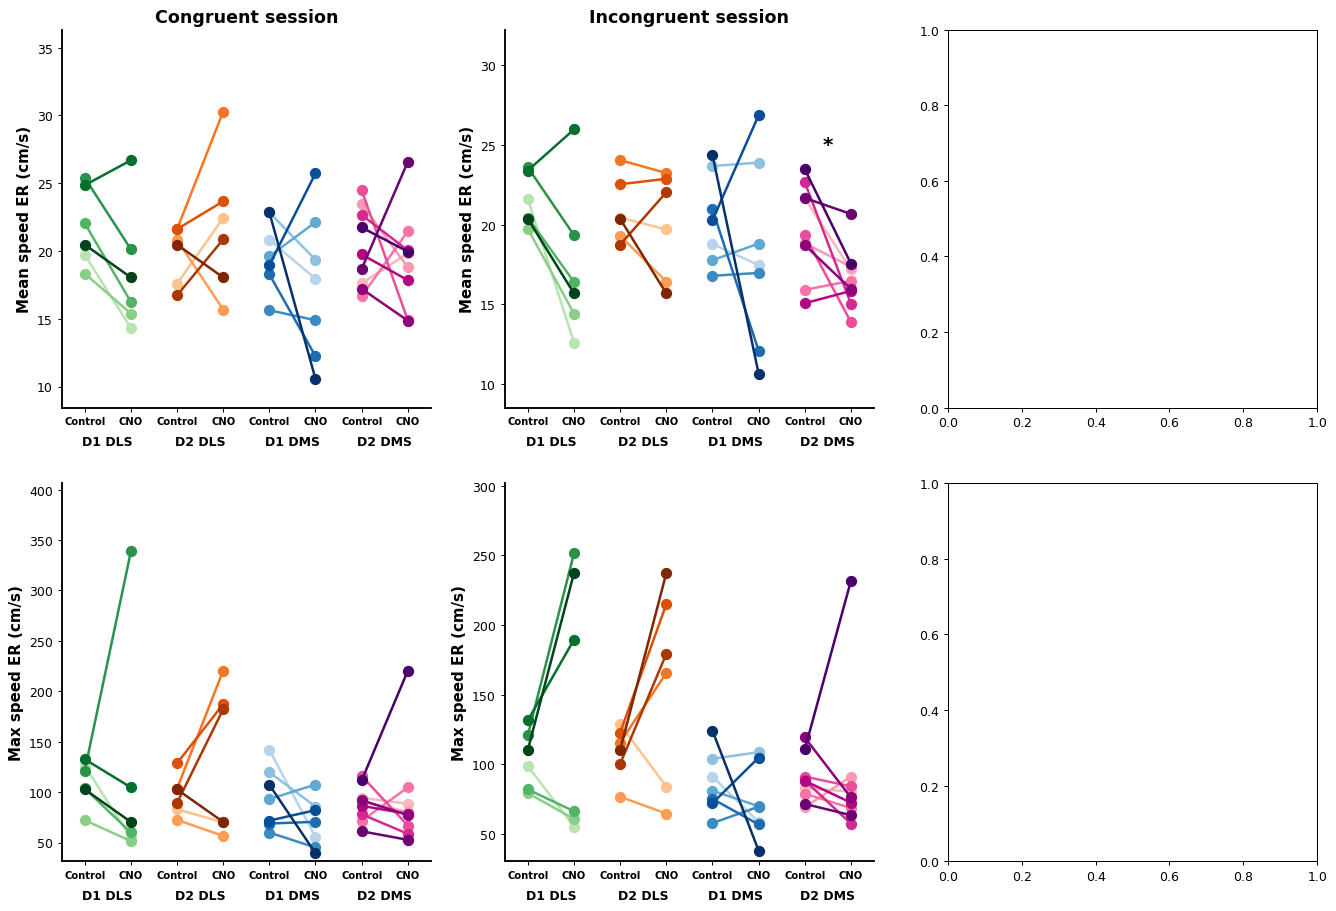

In [24]:
# Plot speeds (mean/max) of ER with plot_metric_comparison_by_group

fig, axs = plt.subplots(2,3,figsize=(18, 12), dpi=90)

plot_metric_comparison_by_group(axs[0,0], meanspeed_ER_dict, "Mean speed ER (cm/s)", groups, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[0,1], meanspeed_ER_dict, "Mean speed ER (cm/s)", groups, bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[0,2], meanspeed_ER_dict, "Mean speed ER (cm/s)", groups, bias_direction="Mixed")

plot_metric_comparison_by_group(axs[1,0], maxspeed_ER_dict, "Max speed ER (cm/s)", groups, set_title=False, bias_direction="Congruent")
plot_metric_comparison_by_group(axs[1,1], maxspeed_ER_dict, "Max speed ER (cm/s)", groups, set_title=False,bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[1,2], maxspeed_ER_dict, "Max speed ER (cm/s)", groups, set_title=False,bias_direction="Mixed")

plt.show()

## Other functions to compare metrics between groups

#### Compare metrics between groups along 4 sessions (Control/CNO, morning/afternoon)

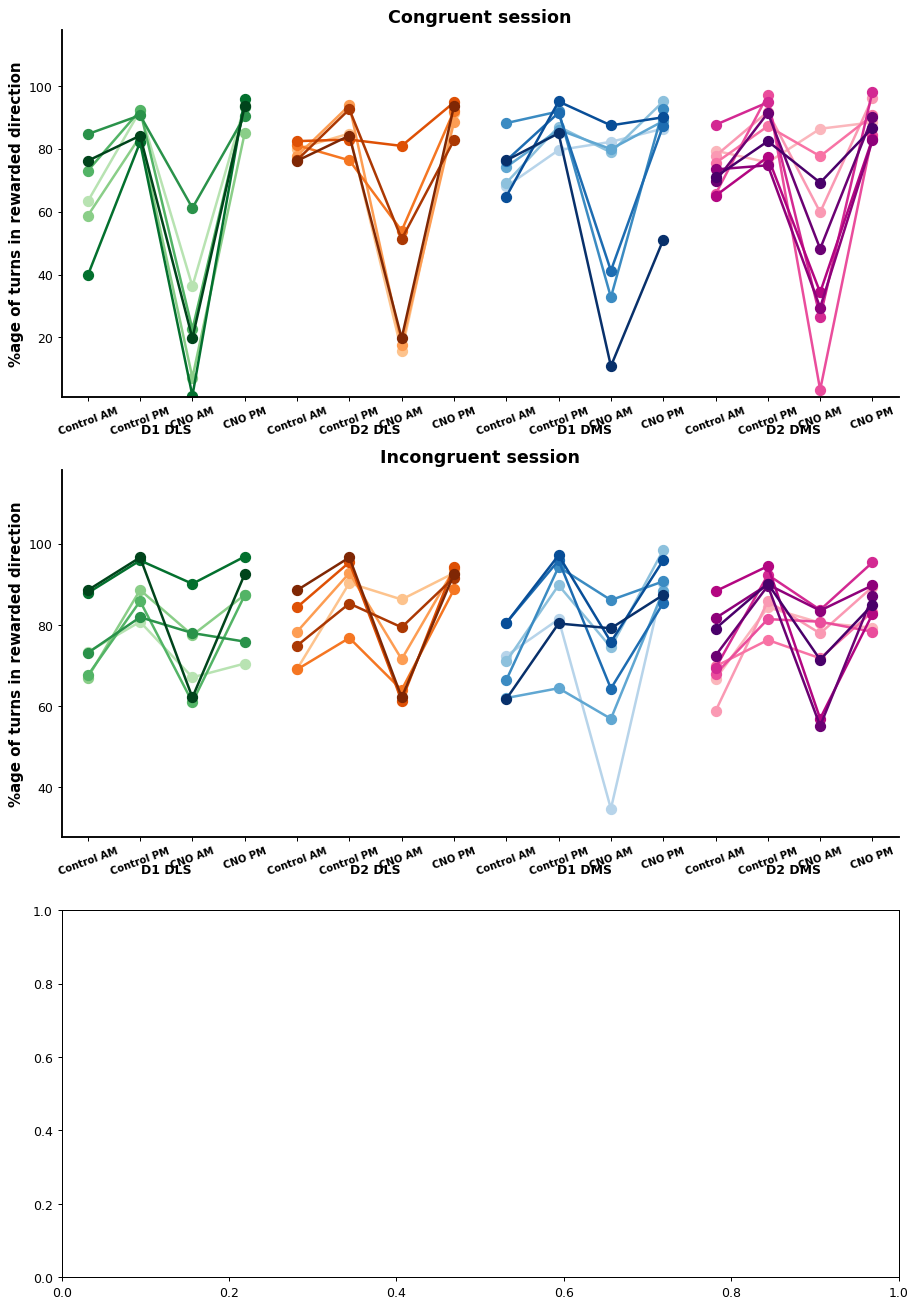

In [26]:
# Function to plot a metric in control vs CNO session (morning vs afternoon)

def plot_metric_by_group_4sessions(ax, metric_dict, metric_name, groups, set_title=True, bias_direction="congruent"):
    """
    Compares a metric before and after CNO injection for each group, with an improved display.
    This version displays 4 sessions: "Control AM", "Control PM", "CNO AM", "CNO PM".

    :param ax: Matplotlib axis on which to draw the graph.
    :param metric_dict: Dictionary of metrics for each mouse.
    :param metric_name: Name of the metric to display on the Y axis.
    :param groups: Dictionary of mouse groups (group name → list of mice).
    :param bias_direction: "congruent", "incongruent", or "mixed".
    """

    # Selection of CNO sessions based on bias
    if bias_direction == "Mixed":
        session_cno_am_selected = {mouse: session_cno_indices["cno_third"] for mouse in mice_list}
    else:
        session_cno_am_selected = {
            mouse: session_cno_indices["cno_second"] if mouse in batch_starting_incongruent 
            else session_cno_indices["cno_first"]
            for mouse in mice_list
        } if bias_direction == "Congruent" else {
            mouse: session_cno_indices["cno_first"] if mouse in batch_starting_incongruent 
            else session_cno_indices["cno_second"]
            for mouse in mice_list
        }

    session_control_am_selected = {mouse: idx - 4 for mouse, idx in session_cno_am_selected.items()}
    session_control_pm_selected = {mouse: idx - 3 for mouse, idx in session_cno_am_selected.items()}
    session_cno_pm_selected = {mouse: idx + 1 for mouse, idx in session_cno_am_selected.items()}

    tick_positions = []
    session_labels = []
    group_annotations = []
    
    all_data = []

    # Loop through each group to retrieve the data and plot the points
    for i, (group_name, group_mice) in enumerate(groups.items()):
        group_control_am_data = []
        group_control_pm_data = []
        group_cno_am_data = []
        group_cno_pm_data = []
        
        cmap = plt.get_cmap(colormaps.get(group_name))  # Group-specific colormap
        colors = cmap(np.linspace(0.3, 1, len(group_mice)))  # Color gradient for group mice
        
        for j, mouse in enumerate(group_mice):
            if mouse in metric_dict:
                if (
                    session_control_am_selected[mouse] in metric_dict[mouse] and 
                    session_control_pm_selected[mouse] in metric_dict[mouse] and
                    session_cno_am_selected[mouse] in metric_dict[mouse] and
                    session_cno_pm_selected[mouse] in metric_dict[mouse]
                ):
                    control_am = metric_dict[mouse][session_control_am_selected[mouse]]
                    control_pm = metric_dict[mouse][session_control_pm_selected[mouse]]
                    cno_am = metric_dict[mouse][session_cno_am_selected[mouse]]
                    cno_pm = metric_dict[mouse][session_cno_pm_selected[mouse]]

                    group_control_am_data.append(control_am)
                    group_control_pm_data.append(control_pm)
                    group_cno_am_data.append(cno_am)
                    group_cno_pm_data.append(cno_pm)
                    all_data.extend([control_am, control_pm, cno_am, cno_pm])

                    # Positions on the X axis
                    control_am_pos = i * 4
                    control_pm_pos = i * 4 + 1
                    cno_am_pos = i * 4 + 2
                    cno_pm_pos = i * 4 + 3

                    # Drawing lines and points
                    ax.plot([control_am_pos, control_pm_pos, cno_am_pos, cno_pm_pos], 
                            [control_am, control_pm, cno_am, cno_pm], 
                            color=colors[j], linewidth=2, linestyle='-', marker='o', markersize=8)

        # Added positions and labels for the X axis
        tick_positions.extend([i * 4, i * 4 + 1, i * 4 + 2, i * 4 + 3])
        session_labels.extend(["Control AM", "Control PM", "CNO AM", "CNO PM"])

        # Add group annotation
        group_annotations.append((i * 4 + 1.5, group_name))

    # Axis configuration
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(session_labels, fontsize=10, fontweight='bold', rotation=20)

    # Displaying group names below pairs of points
    for pos, group_name in group_annotations:
        ax.annotate(group_name, xy=(pos, -0.1), xycoords=('data', 'axes fraction'), ha='center', fontsize=10, fontweight='bold')

    if set_title:
        ax.set_title(f"{bias_direction} session", fontsize=14, fontweight='bold')
    ax.set_ylabel(metric_name, fontsize=12, fontweight='bold')

    # Automatic definition of ylim with a 20% margin
    if all_data:
        ax.set_ylim(min(all_data) * 0.8, max(all_data) * 1.2)

    ax.set_xlim(-0.5, len(groups) * 4 - 0.5)

    # Removed grids for a cleaner display
    ax.grid(False)

    # Customizing the axes
    ax.tick_params(axis='y', which='major', labelsize=10)
    ax.tick_params(axis='x', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

# Example of use
fig, axs = plt.subplots(3 ,1, figsize=(12, 18), dpi=90)
plot_metric_by_group_4sessions(axs[0], success_percentage_dict, "%age of turns in rewarded direction", groups, bias_direction="Congruent")
plot_metric_by_group_4sessions(axs[1], success_percentage_dict, "%age of turns in rewarded direction", groups, bias_direction="Incongruent")
# plot_metric_by_group_4sessions(axs[2], success_percentage_dict, "%age of turns in rewarded direction", groups, bias_direction="Mixed")
plt.show()


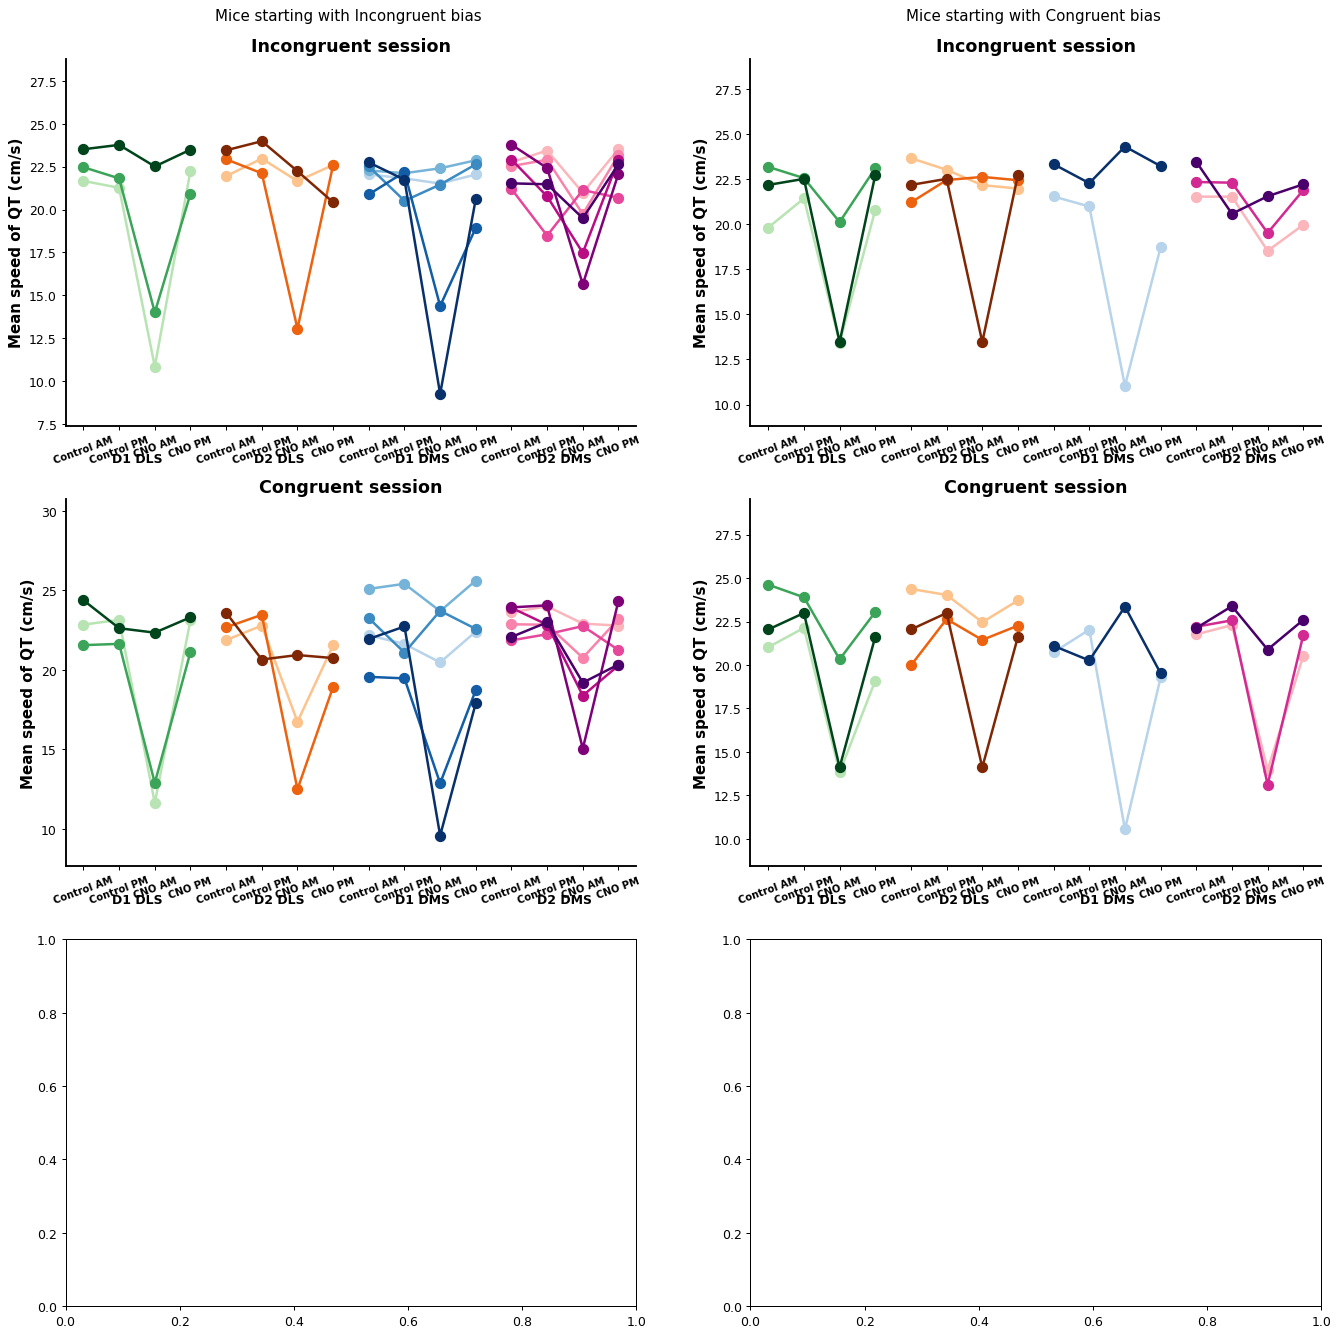

In [27]:
def plot_metric_by_group_4sessions_with_custom_mice(axs, metric_dict, metric_name, groups, mice_to_use, bias_direction="congruent"):
    """
    Plots the success percentage metric for mice in the specified list (mice_to_use) grouped by original groups.

    :param axs: List of two axes (ax1 for selected mice group).
    :param metric_dict: Dictionary of metrics for each mouse.
    :param metric_name: Name of the metric to display on the Y axis.
    :param groups: Dictionary of mouse groups (group name → list of mice).
    :param mice_to_use: List of mice to include in the plot (can be batch_starting_incongruent or batch_starting_congruent).
    :param bias_direction: "congruent", "incongruent" or "mixed".
    """
    # Sélectionner les groupes en fonction de la liste de souris spécifiée (mice_to_use)
    selected_groups = {group: [mouse for mouse in group_mice if mouse in mice_to_use] for group, group_mice in groups.items()}

    # Appeler la fonction de tracé pour afficher les résultats de cette liste de souris
    plot_metric_by_group_4sessions(axs, metric_dict, metric_name, selected_groups, bias_direction=bias_direction)

# Exemple d'utilisation avec batch_starting_incongruent et batch_starting_congruent
fig, axs = plt.subplots(3, 2, figsize=(18, 18), dpi=90)

plot_metric_by_group_4sessions_with_custom_mice(axs[0,0], meanspeed_QT_dict, "Mean speed of QT (cm/s)", groups, batch_starting_incongruent, bias_direction="Incongruent")
plot_metric_by_group_4sessions_with_custom_mice(axs[0,1], meanspeed_QT_dict, "Mean speed of QT (cm/s)", groups, batch_starting_congruent, bias_direction="Incongruent")
plot_metric_by_group_4sessions_with_custom_mice(axs[1,0], meanspeed_QT_dict, "Mean speed of QT (cm/s)", groups, batch_starting_incongruent, bias_direction="Congruent")
plot_metric_by_group_4sessions_with_custom_mice(axs[1,1], meanspeed_QT_dict, "Mean speed of QT (cm/s)", groups, batch_starting_congruent, bias_direction="Congruent")
# plot_metric_by_group_4sessions_with_custom_mice(axs[2,0], meanspeed_QT_dict, "Mean speed of QT (cm/s)", groups, batch_starting_incongruent, bias_direction="Mixed")
# plot_metric_by_group_4sessions_with_custom_mice(axs[2,1], meanspeed_QT_dict, "Mean speed of QT (cm/s)", groups, batch_starting_congruent, bias_direction="Mixed")

# Ajouter du texte sur les graphiques
axs[0,0].text(0.5, 1.05, 'Mice starting with Incongruent bias \n', ha='center', va='bottom', fontsize=12, transform=axs[0,0].transAxes)
axs[0,1].text(0.5, 1.05, 'Mice starting with Congruent bias \n', ha='center', va='bottom', fontsize=12, transform=axs[0,1].transAxes)

plt.show()


🧪 D1 DLS: Wilcoxon test Congruent vs Incongruent → p-value = 0.0312
🧪 D1 DMS: Wilcoxon test Congruent vs Mixed → p-value = 0.0312
🧪 D2 DMS: Wilcoxon test Congruent vs Incongruent → p-value = 0.0391


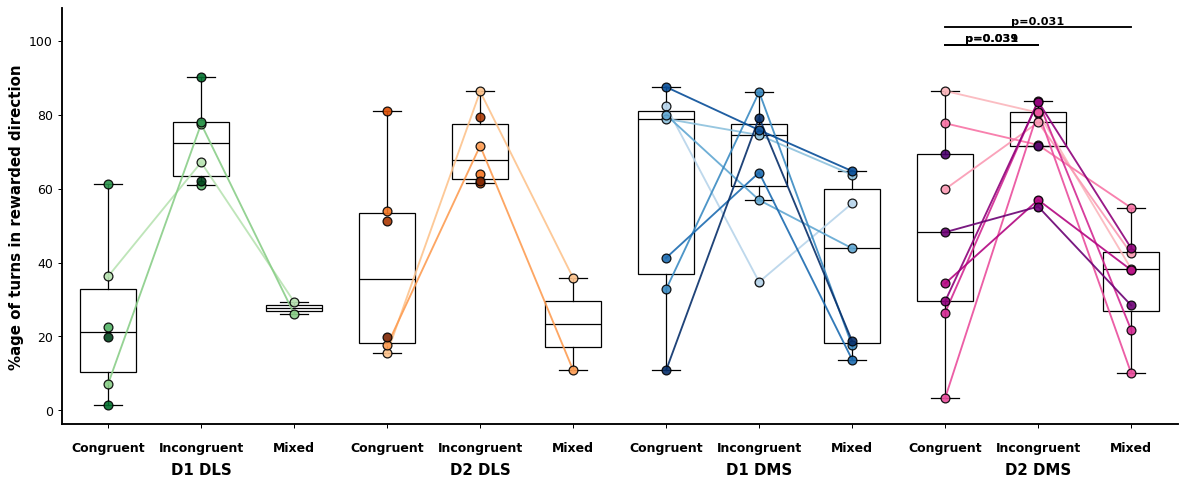

In [28]:
def plot_metric_comparison_by_bias(ax, metric_dict, metric_name, groups):
    """
    Compares a metric between the Congruent, Incongruent, and Mixed sessions for each group.
    Adds boxplots without gray backgrounds, plots matching lines, and performs a Wilcoxon test.

    :param ax: Matplotlib axis on which to plot the graph.
    :param metric_dict: Dictionary containing the metric values ​​for each mouse.
    :param metric_name: Name of the metric to display on the Y axis.
    :param groups: Dictionary of mouse groups (group name → list of mice).
    """

    bias_conditions = ["Congruent", "Incongruent", "Mixed"]
    tick_positions = []
    group_annotations = []
    all_data = []
    scatter_data = []
    
    p_values = {}  # Store p-values ​​from Wilcoxon tests

    for i, (group_name, group_mice) in enumerate(groups.items()):
        cmap = plt.get_cmap(colormaps.get(group_name))  # Group-specific colormap
        colors = cmap(np.linspace(0.3, 1, len(group_mice)))  # Color gradient for group mice

        group_values = {bias: [] for bias in bias_conditions}
        individual_lines = {mouse: [] for mouse in group_mice}

        for j, mouse in enumerate(group_mice):
            if mouse in metric_dict:
                session_indices = {
                    "Congruent": (session_cno_indices["cno_second"] if mouse in batch_starting_incongruent 
                                  else session_cno_indices["cno_first"]),
                    "Incongruent": (session_cno_indices["cno_first"] if mouse in batch_starting_incongruent 
                                    else session_cno_indices["cno_second"]),
                    "Mixed": session_cno_indices["cno_third"]
                }

                for bias in bias_conditions:
                    session_idx = session_indices[bias]

                    if session_idx in metric_dict[mouse]:  
                        value = metric_dict[mouse][session_idx]  # Retrieving the value for this session
                        group_values[bias].append(value)
                        scatter_data.append((i * 3 + bias_conditions.index(bias), value, colors[j]))
                        individual_lines[mouse].append((i * 3 + bias_conditions.index(bias), value, colors[j]))

        # 🔹 Drawing lines connecting the same individuals across conditions
        for mouse, points in individual_lines.items():
            if len(points) == 3:  # Check that we have the 3 values ​​for this animal
                x_vals, y_vals, color = zip(*points)
                ax.plot(x_vals, y_vals, color=color[0], linewidth=1.5, alpha=0.9, zorder=2)

        # 📌 Adding boxplots
        data_boxplot = [group_values[bias] for bias in bias_conditions]
        ax.boxplot(data_boxplot, positions=[i * 3, i * 3 + 1, i * 3 + 2], widths=0.6, patch_artist=True, 
                   boxprops=dict(facecolor='white', color='black'), medianprops=dict(color='black'),
                   whiskerprops=dict(color='black'), capprops=dict(color='black'), zorder=1)

        # 🔬 Wilcoxon paired-rank test between biases
        pairs = [("Congruent", "Incongruent"), ("Congruent", "Mixed"), ("Incongruent", "Mixed")]
        for (bias1, bias2) in pairs:
            if len(group_values[bias1]) > 1 and len(group_values[bias2]) > 1:
                try:
                    stat, p_value = wilcoxon(group_values[bias1], group_values[bias2])
                    p_values[(group_name, bias1, bias2)] = p_value
                except ValueError:  # Error if data is identical
                    p_values[(group_name, bias1, bias2)] = 1.0

        tick_positions.extend([i * 3, i * 3 + 1, i * 3 + 2])
        group_annotations.append((i * 3 + 1, group_name))

    # 🔹 Displaying individual points
    for x, y, color in scatter_data:
        ax.scatter(x, y, color=color, edgecolor='black', s=50, alpha=0.9, zorder=2)

    # 🔹 Add p-values ​​to the graph if significant
    y_max_group = max(max(group_values["Congruent"]), max(group_values["Incongruent"]), max(group_values["Mixed"])) * 1.1
    height_offset = {("Congruent", "Incongruent"): 1.05, ("Congruent", "Mixed"): 1.10, ("Incongruent", "Mixed"): 1.15}
    for (group, bias1, bias2), p_value in p_values.items():
        if p_value <= 0.05:
            x_pos1 = i * 3 + bias_conditions.index(bias1)
            x_pos2 = i * 3 + bias_conditions.index(bias2)
            heigh_p_value = y_max_group * height_offset[(bias1, bias2)]
            ax.plot([x_pos1, x_pos2], [heigh_p_value-0.9, heigh_p_value-0.9], color='black', linewidth=1.5)
            ax.text((x_pos1 + x_pos2) / 2, heigh_p_value, f"p={p_value:.3f}", ha='center', fontsize=9, fontweight='bold')


    # 🔹 Axis configuration
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(bias_conditions * len(groups), fontsize=10, fontweight='bold', rotation=0, ha='center')
    ax.xaxis.set_tick_params(pad=10)  # Increases the vertical spacing between ticks and the X axis

    # 🔹 Added group labels at the bottom
    for pos, group_name in group_annotations:
        ax.annotate(group_name, xy=(pos, -0.12), xycoords=('data', 'axes fraction'), ha='center', fontsize=12, fontweight='bold')

    ax.set_ylabel(metric_name, fontsize=12, fontweight='bold')
    # ax.set_title(f"Comparison of {metric_name} across bias conditions", fontsize=14, fontweight='bold')

    # 🔹 Y scale adjustment
    if all_data:
        ax.set_ylim(min(all_data) * 0.8, max(all_data) * 1.2)

    ax.set_xlim(-0.5, len(groups) * 3 - 0.5)

    # 🔹 Removed grids for a cleaner display
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    # 🔬 Displaying p-values ​​in the console
    for (group, bias1, bias2), p_value in p_values.items():
        if p_value <= 0.05:
            print(f"🧪 {group}: Wilcoxon test {bias1} vs {bias2} → p-value = {p_value:.4f}")

# 📊 Example of use
fig, ax = plt.subplots(figsize=(16, 6), dpi=90)
plot_metric_comparison_by_bias(ax, 
                               metric_dict=success_percentage_dict, 
                               metric_name="%age of turns in rewarded direction", 
                               groups=groups)
plt.show()


## Analysis depending on the reward history

#### First: step-by-step analysis of speed after (un)rewarded run around towers

In [29]:
# Initialisation des dictionnaires de QT après un QT (un)rewarded
qt_after_rewarded_dict = {}
qt_after_unrewarded_dict = {}

# Parcours des données
for mouse, sessions in runs_around_tower_dict.items():
    qt_after_rewarded_dict[mouse] = {}
    qt_after_unrewarded_dict[mouse] = {}
    
    for session_index, qt_list in sessions.items():
        qt_after_rewarded_dict[mouse][session_index] = []
        qt_after_unrewarded_dict[mouse][session_index] = []
        
        for i in range(len(qt_list) - 1):  # On s'arrête à l'avant-dernier QT
            current_qt = qt_list[i]
            next_qt = qt_list[i + 1]
            
            if current_qt[3]['Rewarded']:  # Vérification si le QT actuel est rewardé
                qt_after_rewarded_dict[mouse][session_index].append(next_qt)
            else:
                qt_after_unrewarded_dict[mouse][session_index].append(next_qt)



In [30]:
# Functions to plot a trajectory speed chunk

def cm2inch(value):

    """
    Converts centimeters to inches for figure size.

    Arguments:
        value (float): value to convert in cm 

    """

    return value/2.54

def detect_raw_and_clean_run_epochs(speeds, time):
    
    """
    Identifies continuous epochs during which the mouse is moving above a certain speed (cut_off_speed).
    A minimal duration of low speed is necessary to be considered as the end of a run.
    Similarly, a minimal duration of high speed is necessary to be considered as a run.

    Arguments:
        speeds (list): speed of the mouse at every point of the trajectory
        time_video_frames (list): time of every point of the trajectory

    Returns:
        run_epochs (list): List of frame intervals during which a run occurs accordin to the speed threshold
        clean_run_epochs (list): List of frame intervals during which a run occurs, extended with frames adjacent to the first/last one 
                                 where the acceleration is at least 10% of the acceleration when going above/below the speed threshold.

    """
    
    # For this we need some parameters to cut the trajectory into run based on speed, duration of runs and pauses
    pause_min_duration = 0.1 # If a stop is shorter than this, merges the two epochs bordering it
    run_min_duration = 0.3 # Minimal duration of an epoch to be considerd
    cut_off_speed = 7 # This value is the speed in cm/s. It is used to detect when the animals stop running.     
    
    # Create a list to store run epochs
    run_epochs = []
    # Flag to track if we are currently in a running epoch
    is_in_epoch = False  
    # Initialise the starting index of the first epoch
    epoch_start_index = 0

    # Raises an error if the speed and time vectors don't have the same number of values
    if len(speeds) != len(time):
        raise ValueError("speeds and time_video_frames have different lengths")

    # Iterate on speed
    for i in range(len(speeds)):

        # Check if speed above cut-off value
        if speeds[i] >= cut_off_speed:
            # Check if the previous trajectory speed was part of running epoch. If not this will be a start of a new epoch
            if not is_in_epoch:
                # Mark the beginning of a new epoch
                epoch_start_index = i  
                # Change flag to indicate the current speed belongs to a the current epoch
                is_in_epoch = True
        else: # the speed of the current data point is below the treshold
            if is_in_epoch: # if we were in a run epoch just before (1st point below the treshold)
                # Check first if the pause between this epoch's starting point (time_video_frames[epoch_start_index]) and  
                # the previous epoch's last point time_video_frames[run_epochs[-1][1]] is shorter than the minimal time for a pause.
                # If it is, the previous epoch should be extended to the previous data point.  
                if run_epochs and (time[epoch_start_index] - time[run_epochs[-1][1]] < pause_min_duration):
                    run_epochs[-1][1] = i - 1  # Extend the previous epoch
                else: # the pause has been long enough then we terminate the run epoch  other previous 
                    run_epochs.append([epoch_start_index, i - 1])  # Add new epoch
                # Change flag to indicate the current speed belongs to a new epoch
                is_in_epoch = False

    # Check for any epoch still in progress after having processed the last speed value
    if is_in_epoch:
        # Check if run_epochs is not empty and the difference between the last time of the trajectory and the epoch start time is lower than pause_min_duration
        if run_epochs and (time[epoch_start_index] - time[run_epochs[-1][1]] < pause_min_duration):
            # If it is not, sets the last speed value as its end
            run_epochs[-1][1] = len(speeds) - 1
        # Else, check if the difference between the last time of the trajectory and the epoch start time is higher than pause_min_duration
        elif (time[-1] - time[epoch_start_index]) >= run_min_duration:
            run_epochs.append([epoch_start_index, len(speeds) - 1])

    # Remove epochs that are too short
    run_epochs = [epoch for epoch in run_epochs if (time[epoch[1]] - time[epoch[0]]) >= run_min_duration]
    
    # Adjust the start and end of each epoch based on acceleration, to take into account the initiation of the movement. 
    # Find the point at wich the animal acceleration is less than 10% of the acceleration at the moment
    # at which it goes above the speed treshold.
    
    # Initialize a list of None of the length of run_epochs, that will contain the run epochs extended by the method described above. 
    clean_run_epochs = [None] * len(run_epochs)
    # Iterate on all epochs
    for index,epoch in enumerate(run_epochs):
        # Copy the current epoch in clean_run_epochs at the same index
        clean_run_epochs[index] = epoch.copy()
        # Define the start and end index of the epoch
        epoch_start, epoch_end = epoch[0], epoch[1]
        # Compute the acceleration when going above the speed threshold
        current_point = epoch_start
        acceleration_at_crossing=(speeds[current_point + 1] - speeds[current_point]) / (time[current_point + 1] - time[current_point])
        
        # Iterate on indexes backward from the start of the epoch 
        while current_point > 0:
            # Compute the acceleration at the previous index
            previous_acceleration = (speeds[current_point] - speeds[current_point - 1]) / (time[current_point] - time[current_point - 1])
            # Check if this acceleration is lower than or equal to 10% of the crossing acceleration
            if previous_acceleration <= (0.1 * acceleration_at_crossing) or previous_acceleration <= 0:
                # If it is, stops to iterate on indexes. current_point is then the last index before acceleration is higher than or equal to 10% 
                break
            current_point -= 1
        
        # Set the beginning of the epoch at current_point
        clean_run_epochs[index][0] = current_point

        # Adjust the end of the epoch
        # Find the point at wich the animal acceleration is less than 10% of the acceleration at the moment
        # at which it goes above the speed treshold.        
        
        # Compute the acceleration when going bellow the speed threshold
        current_point = epoch_end
        acceleration_at_crossing=(speeds[current_point - 1] - speeds[current_point]) / (time[current_point] - time[current_point-1])
        # Iterate on indexes forward from the end of the epoch
        while current_point < len(speeds) - 1:
            # Compute the acceleration at the next index
            next_acceleration = (speeds[current_point] - speeds[current_point + 1]) / (time[current_point+1] - time[current_point])
            # Check if this acceleration is lower than or equal to 10% of the crossing acceleration
            if next_acceleration <= (0.1 * acceleration_at_crossing) or next_acceleration <= 0:
                # If it is, stops to iterate on indexes. current_point is then the last point before acceleration is lower than or equal to 10%
                break
            current_point += 1

        # Set the beginning of the epoch at current_point
        clean_run_epochs[index][1] = current_point

   
    return run_epochs, clean_run_epochs

def find_run_type(run_epoch, folder_path_mouse_to_analyse, example_mouse, session_index, qt_after_rewarded_dict, qt_after_unrewarded_dict, start_session_index=0):
    """
    Determines the type of run epoch by loading session data from a pickle file.

    Arguments:
        run_epoch (int): The epoch ID to classify.
        folder_path_mouse_to_analyse (str): Path to the folder containing session data.
        session_index (int): Index of the session from which the run epoch will be classified.
        start_session_index (int, optional): index of the first session in the list of sessions to analyse. 
                                   If different from 0, the session index should refer to 
                                   the index of the session in the sub-list of session to process, not the total list 
        qt_after_rewarded_dict (dict, optional): Dictionary containing QTs after rewarded QTs.
        qt_after_unrewarded_dict (dict, optional): Dictionary containing QTs after unrewarded QTs.

    Returns:
        epoch_type (str): The classified type of the run epoch (e.g., 'run_around_tower', 'exploratory_run', etc.).
    """

    # Initialize epoch_type to avoid UnboundLocalError
    epoch_type = "unclassified"

    # Get all session folders that start with 'MOU' and sort them
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])

    session_to_analyse = sessions_to_analyse[start_session_index+session_index]

    # Define the pickle file path
    output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"
    output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)
    
    # Load the pickle file containing session data
    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    # Extract epoch start and end frames, and consider it is their IDs for different movement types
    # run_around_tower_ids = np.array([item[0] for item in session_data['all_epochs']['run_around_tower']])
    TAT_after_rew_ids = np.array([item[0] for item in qt_after_rewarded_dict[example_mouse][session_index]])
    TAT_after_unrew_ids = np.array([item[0] for item in qt_after_unrewarded_dict[example_mouse][session_index]])
    run_between_towers_ids = np.array([item[0] for item in session_data['all_epochs']['run_between_towers']])
    exploratory_run_ids = np.array([item[0] for item in session_data['all_epochs']['exploratory_run']])
    run_toward_tower_ids = np.array([item[0] for item in session_data['all_epochs']['run_toward_tower']])

    # Check if the given run_epoch belongs to any of the predefined categories
    # condition_1 = run_epoch[0] in [item[0] for item in session_data['all_epochs']['run_around_tower']]
    condition_1 = run_epoch[0] in [item[0] for item in qt_after_rewarded_dict[example_mouse][session_index]]
    condition_2 = run_epoch[0] in [item[0] for item in qt_after_unrewarded_dict[example_mouse][session_index]]
    condition_3 = run_epoch[0] in [item[0] for item in session_data['all_epochs']['run_between_towers']]
    condition_4 = run_epoch[0] in [item[0] for item in session_data['all_epochs']['run_toward_tower']]
    condition_5 = run_epoch[0] in [item[0] for item in session_data['all_epochs']['exploratory_run']]
    condition_6 = run_epoch[0] in [item[0] for item in session_data['all_epochs']['immobility']]

    # Extract immobility epochs (which start and )
    immobility_ids = np.array([[item[0], item[1]] for item in session_data['all_epochs']['immobility']])
    
    # Check if the given run_epoch belongs to any of the predefined categories
    # condition_1 = run_epoch in run_around_tower_ids
    condition_1 = run_epoch in TAT_after_rew_ids
    condition_2 = run_epoch in TAT_after_unrew_ids
    condition_3 = run_epoch in run_between_towers_ids
    condition_4 = run_epoch in run_toward_tower_ids
    condition_5 = run_epoch in exploratory_run_ids
    condition_6 = run_epoch in immobility_ids  

    # Determine the type of the run epoch
    if np.any(condition_1):
        epoch_type = "run_around_tower_after_rewarded"
    elif np.any(condition_2):
        epoch_type = "run_around_tower_after_unrewarded"
    
    # if np.any(condition_1):
    #     if session_index in qt_after_rewarded_dict[example_mouse]:
    #         rewarded_qts = qt_after_rewarded_dict[example_mouse][session_index]
    #     else:
    #         rewarded_qts = []

    #     # Vérifiez si session_index est une clé dans le dictionnaire
    #     if session_index in qt_after_unrewarded_dict[example_mouse]:
    #         unrewarded_qts = qt_after_unrewarded_dict[example_mouse][session_index]
    #     else:
    #         unrewarded_qts = []

    #     # Utilisez ces listes pour vérifier les conditions
    #     if qt_after_rewarded_dict and any(run_epoch == qt[:2] for qt in rewarded_qts):
    #         epoch_type = "run_around_tower_after_rewarded"
    #     elif qt_after_unrewarded_dict and any(run_epoch == qt[:2] for qt in unrewarded_qts):
    #         epoch_type = "run_around_tower_after_unrewarded"
        # else:
        #     epoch_type = "run_around_tower"

    elif np.any(condition_3):
        epoch_type = "run_between_towers"
    elif np.any(condition_4):
        epoch_type = "run_toward_tower"    
    elif np.any(condition_5):
        epoch_type = "exploratory_run"
    elif np.any(condition_6):
        epoch_type = "immobility"    
    else:
        # print("WARNING: unclassified epoch")
        epoch_type = "unclassified"

    return epoch_type

def plot_selected_run_epochs(folder_path_mouse_to_analyse, example_mouse, session_index, first_epoch_to_plot, last_epoch_to_plot, arena_coordinates, ax, start_session_index=0, points_for_direction=4, show_legend=True):
    """
    Plots selected run epochs from a session.

    Arguments:
        folder_path_mouse_to_analyse (str): Path to the folder containing session data.
        session_index (int): Index of the session to analyse.
        first_epoch_to_plot (int): Index of the first epoch to plot.
        last_epoch_to_plot (int): Index of the last epoch to plot.
        arena_coordinates (list): List of four 2D coordinates, locating the corners of the arena.
        ax (matplotlib.axes.Axes): Matplotlib axis object for plotting.
        start_session_index (int, optional): index of the first session in the list of sessions to analyse. 
                                   If different from 0, the session index should refer to 
                                   the index of the session in the sub-list of session to process, not the total list.
        points_for_direction (int, optional): Number of points used to determine movement direction. Default is 4.
        show_legend (bool, optional): Whether to show a legend. Default is True.

    Returns:
        (int): Start index of the first plotted epoch.
        (int): End index of the last plotted epoch.
        (list): List of trapeze switch times during the plotted epochs.
    """

    # Get all session folders that start with 'MOU' and sort them
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])

    session_to_analyse = sessions_to_analyse[start_session_index+session_index]

    # Define the pickle file path
    output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"        
    output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)

    # Load session data from the pickle file
    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    # Load additional data related to the session
    traj_df, turns_df, param_df = load_data(folder_path_mouse_to_analyse, session_to_analyse)

    # Extract session parameters
    traject_time = session_data['timeofframes']
    speeds = session_data['speeds']
    smoothed_positions = session_data['positions']
    smoothed_Xpositions = smoothed_positions[0]
    smoothed_Ypositions = smoothed_positions[1]
    all_trapezes_coordinates_cm = session_data['all_trapezes_coordinates_cm']

    # Detect run epochs
    clean_run_epochs = detect_run_epochs(speeds, traject_time)

    # Define run types and corresponding colors
    run_types = ["run_around_tower_after_rewarded", "run_around_tower_after_unrewarded", "run_between_towers", "run_toward_tower", "exploratory_run", "immobility", "unclassified"]
    type_names = ["Turn around tower (TAT) after rewarded turn", "Turn around tower (TAT) after unrewarded turn", "Run between towers", "Run toward tower", "Exploratory run", "Immobility", "Unclassified"]
    colors = ["forestgreen","red", "darkblue", "fuchsia", "gold", "dimgrey", "black"]

    trapeze_switch_times = []
    all_start_end_indexes = []
    labels_displayed = set()

    # Iterate through selected epochs
    for idx in range(first_epoch_to_plot, last_epoch_to_plot):
        run_epoch = clean_run_epochs[idx]
        start_index, end_index = run_epoch[0], run_epoch[1]
        all_start_end_indexes.extend([start_index, end_index])

        # Check if indexes are within valid bounds
        if start_index < 0 or end_index >= len(traject_time):
            print(f"Indexes out of bounds for run_epoch: {run_epoch}")
            continue

        # Extract trajectory segment for the epoch
        run_epoch = [smoothed_Xpositions[start_index: end_index+1], smoothed_Ypositions[start_index: end_index+1]]
        times_run_epoch = traject_time[start_index: end_index+1]

        # Determine epoch type
        epoch_type = find_run_type([start_index, end_index], folder_path_mouse_to_analyse, example_mouse, session_index, qt_after_rewarded_dict, qt_after_unrewarded_dict)

        # Get corresponding color
        color = colors[run_types.index(epoch_type)]

        # Avoid duplicate legend labels
        if color not in labels_displayed:
            line_label = type_names[run_types.index(epoch_type)]
            labels_displayed.add(color)
        else:
            line_label = ''

        # Plot the trajectory segment
        ax.plot(smoothed_Xpositions[start_index: end_index+1], smoothed_Ypositions[start_index: end_index+1], color=color, linestyle='-', label=line_label)

        # Mark the beginning of the trajectory
        ax.plot(run_epoch[0][0], run_epoch[1][0], marker='o', color='black', markersize=2)

        # Draw an arrow indicating the direction of movement at the end of the last epoch
        if idx + 1 == last_epoch_to_plot:
            dx = smoothed_Xpositions[end_index+1] - smoothed_Xpositions[end_index+1-points_for_direction]
            dy = smoothed_Ypositions[end_index+1] - smoothed_Ypositions[end_index+1-points_for_direction]
            norm_speed = np.hypot(dx, dy)
            if norm_speed != 0:
                dx /= norm_speed
                dy /= norm_speed
            ax.arrow(smoothed_Xpositions[end_index+1], smoothed_Ypositions[end_index+1], dx, dy,
                     head_width=2, head_length=2, fc='black', ec='black', zorder=100)        

        # Extract turns within this trajectory segment
        turns_in_QT = turns_df[(turns_df['time'] >= times_run_epoch[0]) & (turns_df['time'] <= times_run_epoch[-1])]
        trapeze_switch_times.extend(turns_in_QT['time'].values)

    tower_coordinates = session_data['towers_coordinates_cm']
    
    # Plot each tower
    for i, (tower_name, vertices) in enumerate(tower_coordinates.items()):
        tower_x, tower_y = zip(*vertices + [vertices[0]])
        ax.fill(tower_x, tower_y, 'black', alpha=0.01)
        ax.plot(tower_x, tower_y, 'k-', linewidth=0.5)

    # Draw the arena perimeter
    arena_x, arena_y = zip(*arena_coordinates + [arena_coordinates[0]])
    ax.plot(arena_x, arena_y, 'grey', linewidth=1)

    # Define fill colors for trapezes
    fill_colors = ['lightblue'] * 4

    # Plot trapezes
    for i, (tower, trapezes) in enumerate(all_trapezes_coordinates_cm.items()):
        for j, (trapeze, coordinates) in enumerate(trapezes.items()):
            coordinates_copy = coordinates + [coordinates[0]]  # Close the polygon
            x_coords, y_coords = zip(*coordinates_copy)
            ax.fill(x_coords, y_coords, color=fill_colors[j % len(fill_colors)], alpha=0.5)

    # Remove axis spines and labels for a cleaner plot
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

    # Display legend if required
    if show_legend:
        ax.legend(loc=[0.05, -0.35], frameon=False, fontsize=7)

    return all_start_end_indexes[0], all_start_end_indexes[-1], trapeze_switch_times

def plot_trajectory_speed_chunk(start_idx, end_idx, traject_time, speeds, run_epochs, clean_run_epochs, 
                                ax, folder_path_mouse_to_analyse, example_mouse, session_index, start_session_index=0, cut_off_speed=7
                                ):
    """
    Plots the trajectory speeds and highlights run epochs.

    Arguments:
        start_idx (int): Start index of the time window to plot.
        end_idx (int): End index of the time window to plot.
        traject_time (array-like): Array of time points corresponding to the trajectory.
        speeds (array-like): Array of speed values at each time point.
        run_epochs (list): List of tuples containing start and end indices of raw run epochs.
        clean_run_epochs (list): List of tuples containing start and end indices of cleaned run epochs.
        ax (matplotlib.axes.Axes): Matplotlib subplot axis to plot on.
        folder_path_mouse_to_analyse (str): Path to the folder containing mouse session data.
        session_index (int): Session identifier for the data.
        cut_off_speed (float, optional): Speed threshold for highlighting certain speeds. Default is 7 cm/s.
        
    """

    # Plot the trajectory speeds with small markers and a thin line
    ax.plot(
        traject_time[start_idx:end_idx], speeds[start_idx:end_idx], 
        label='Trajectory Speeds', color='black', marker='o', 
        markerfacecolor='none', markersize=0.5, linewidth=0.5, zorder=11
    )
    
    # Draw a horizontal line indicating the cut-off speed threshold
    ax.axhline(y=cut_off_speed, color='orange', linestyle='--', label='Cut-off Speed')

    # Define run types and corresponding colors
    run_types = ["run_around_tower_after_rewarded", "run_around_tower_after_unrewarded", "run_between_towers", "run_toward_tower", "exploratory_run", "immobility", "unclassified"]
    colors = ["forestgreen","red", "darkblue", "fuchsia", "gold", "dimgrey", "black"]

    # Highlight run epochs on the plot
    for idx, clean_epoch in enumerate(clean_run_epochs):
        epoch = run_epochs[idx]  # Corresponding original (raw) run epoch
        
        clean_epoch_start, clean_epoch_end = clean_epoch[0], clean_epoch[1]
        epoch_start, epoch_end = epoch[0], epoch[1]

        # Ensure the epoch falls within the plotting range
        if clean_epoch_start >= start_idx and clean_epoch_end <= end_idx:
            # Determine the run type for the epoch
            clean_epoch_type = find_run_type(clean_epoch, folder_path_mouse_to_analyse, example_mouse, session_index,  qt_after_rewarded_dict, qt_after_unrewarded_dict, start_session_index=start_session_index)

            # Assign color based on the run type
            color = colors[run_types.index(clean_epoch_type)]

            # Highlight cleaned run epochs with a semi-transparent overlay
            ax.axvspan(
                traject_time[clean_epoch_start], traject_time[clean_epoch_end], 
                color=color, alpha=0.3, linewidth=0, 
                label='Adjusted Run Epoch' if idx == 0 else "", zorder=2
            )

            # Highlight original run epochs with a slightly different transparency
            ax.axvspan(
                traject_time[epoch_start], traject_time[epoch_end], 
                color=color, alpha=0.3, linewidth=0, 
                label='Original Run Epoch' if idx == 0 else "", zorder=1
            )
    
    # Set plot limits and labels
    ax.set_ylim(bottom=-5, top=max(speeds[start_idx:end_idx]) * 1.1)
    ax.set_xlabel('Time (s)', fontsize=7)
    ax.set_ylabel('Speed (cm/s)', fontsize=7)


In [31]:
# Select an example mouse and session for the first panel

example_mouse = "MOU4988"
index_example_session = 12

# coordinates in cm of the external walls of the arena # don't know if it will be useful
arena_coordinates_cm = [[2.5, 90.86], [90.3, 90.86], [90.3, 2.7], [2.5, 2.7]]

# Setting the path to the example mouse's data folder
folder_path_example_mouse_to_analyse=os.path.join(path_to_data_folder,example_mouse)

# Find every sessions of the example mouse
example_sessions_to_analyse = sorted([name for name in os.listdir(folder_path_example_mouse_to_analyse)
                                if os.path.isdir(os.path.join(folder_path_example_mouse_to_analyse, name))
                                and name.startswith('MOU')])

# Select the name of the last session
example_session_to_analyse = example_sessions_to_analyse[index_example_session]

# Load the session data from a pickle file
output_example_pickle_filename = f"{example_session_to_analyse}_basic_processing_output.pickle"        
output_example_pickle_filepath = os.path.join(folder_path_example_mouse_to_analyse, example_session_to_analyse, output_example_pickle_filename)

# Open and load the session data from the pickle file
with open(output_example_pickle_filepath, 'rb') as file:
    session_data = pickle.load(file)

# Extract the time and speed of the mouse trajectory for this session
traject_time = session_data['timeofframes']
speeds = session_data['speeds']

# Define epochs
run_epochs, clean_run_epochs= detect_raw_and_clean_run_epochs(speeds,traject_time)

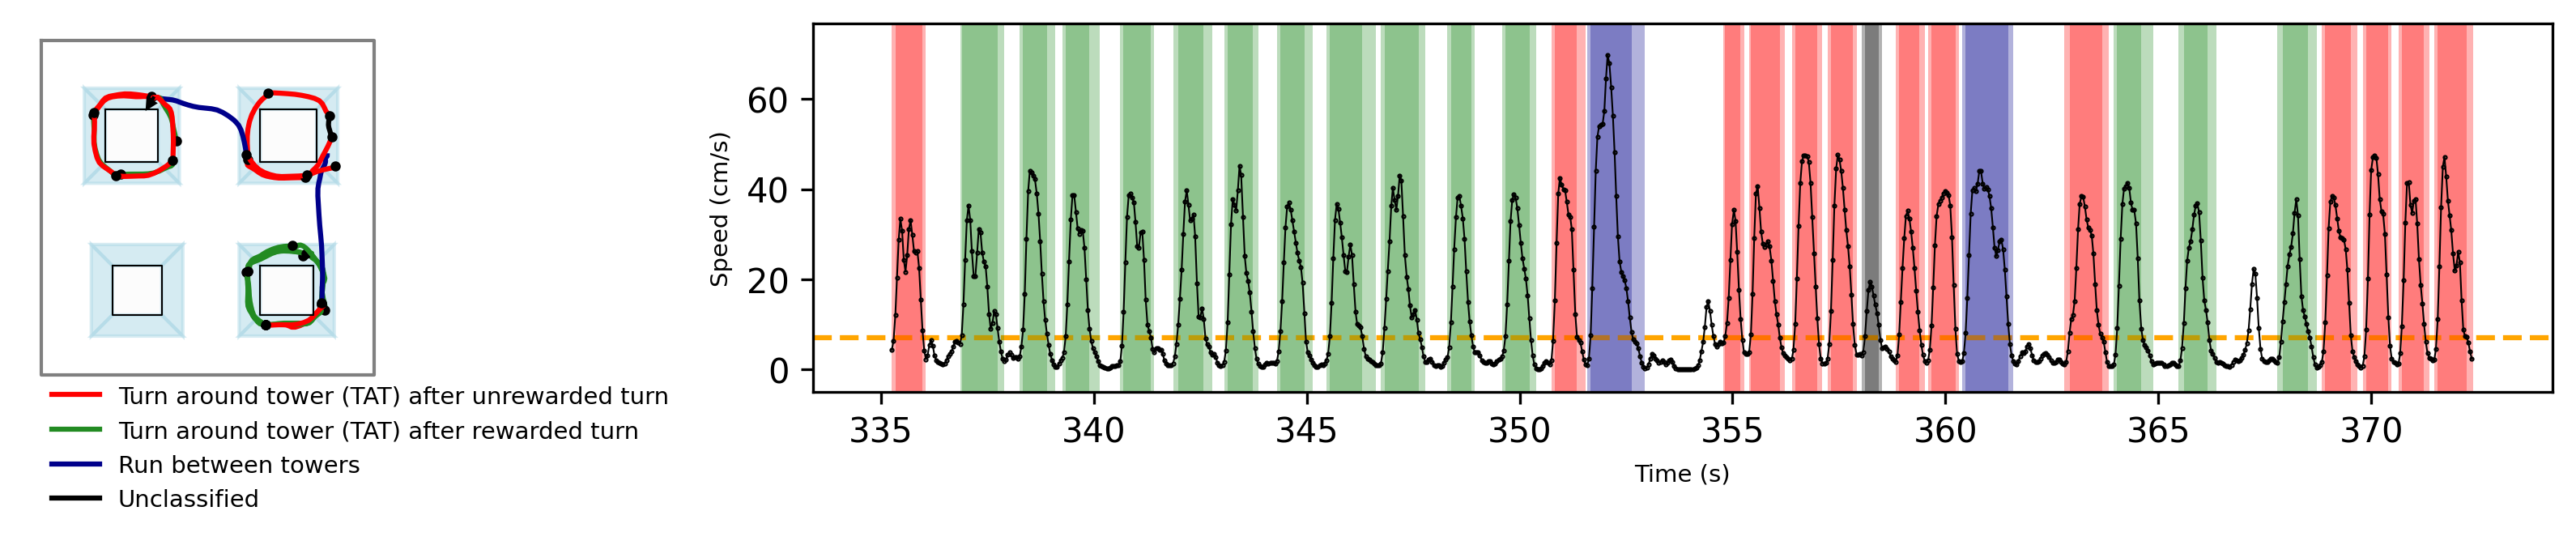

In [32]:
# Select the index of the first and last epochs to show

first_epoch_to_plot = 240
last_epoch_to_plot = 270

fig=plt.figure(figsize=(cm2inch(50), cm2inch(5)), dpi=300, constrained_layout=False, facecolor='w')
gs = fig.add_gridspec(1, 1 , hspace=0.5)

row1 = gs[0].subgridspec(1, 4, wspace=.3, hspace=.3, width_ratios=[1,1,1,1])
ax_11 = plt.subplot(row1[0],aspect="equal")
ax_12 = plt.subplot(row1[1:3])

start_index, end_index, trapeze_switch_times = plot_selected_run_epochs(folder_path_example_mouse_to_analyse, example_mouse, index_example_session, first_epoch_to_plot, last_epoch_to_plot, arena_coordinates_cm, ax_11, show_legend=True)
plot_trajectory_speed_chunk(start_index, end_index, traject_time, speeds, run_epochs, clean_run_epochs, ax_12, folder_path_example_mouse_to_analyse, example_mouse, index_example_session)


#### Second: Analysis of speed of QT after reward or not among sessions

In [33]:
# Initialisation des dictionnaires
meanspeed_after_rewarded = {}
meanspeed_after_unrewarded = {}
median_meanspeed_after_rewarded = {}
median_meanspeed_after_unrewarded = {}

maxspeed_after_rewarded = {}
maxspeed_after_unrewarded = {}
median_maxspeed_after_rewarded = {}
median_maxspeed_after_unrewarded = {}


# Parcours des données
for mouse, sessions in runs_around_tower_dict.items():
    meanspeed_after_rewarded[mouse] = {}
    meanspeed_after_unrewarded[mouse] = {}
    median_meanspeed_after_rewarded[mouse] = {}
    median_meanspeed_after_unrewarded[mouse] = {}

    maxspeed_after_rewarded[mouse] = {}
    maxspeed_after_unrewarded[mouse] = {}
    median_maxspeed_after_rewarded[mouse] = {}
    median_maxspeed_after_unrewarded[mouse] = {}

    
    for session_index, qt_list in sessions.items():

        meanspeed_after_rewarded[mouse][session_index] = []
        meanspeed_after_unrewarded[mouse][session_index] = []
        maxspeed_after_rewarded[mouse][session_index] = []
        maxspeed_after_unrewarded[mouse][session_index] = []
        
        for i in range(len(qt_list) - 1):  # On s'arrête à l'avant-dernier QT
            current_qt = qt_list[i]
            next_qt = qt_list[i + 1]
            
            if current_qt[3]['Rewarded']:  # Vérification si le QT actuel est rewardé
                meanspeed_after_rewarded[mouse][session_index].append(next_qt[4]['epoch_meanspeed'])
                maxspeed_after_rewarded[mouse][session_index].append(next_qt[4]['epoch_maxspeed'])
            else:
                meanspeed_after_unrewarded[mouse][session_index].append(next_qt[4]['epoch_meanspeed'])
                maxspeed_after_unrewarded[mouse][session_index].append(next_qt[4]['epoch_maxspeed'])
        
        # Calcul de la médiane et stockage
        median_meanspeed_after_rewarded[mouse][session_index] = np.median(meanspeed_after_rewarded[mouse][session_index]) if meanspeed_after_rewarded[mouse][session_index] else None
        median_meanspeed_after_unrewarded[mouse][session_index] = np.median(meanspeed_after_unrewarded[mouse][session_index]) if meanspeed_after_unrewarded[mouse][session_index] else None
        median_maxspeed_after_rewarded[mouse][session_index] = np.median(maxspeed_after_rewarded[mouse][session_index]) if maxspeed_after_rewarded[mouse][session_index] else None
        median_maxspeed_after_unrewarded[mouse][session_index] = np.median(maxspeed_after_unrewarded[mouse][session_index]) if maxspeed_after_unrewarded[mouse][session_index] else None



In [31]:
# Plot median of QT mean speed after (un)rewarded QT between groups and before/after CNO injection

# fig, axs = plt.subplots(2,3,figsize=(18, 12))
# plot_metric_comparison_by_group(axs[0,0], speed_after_rewarded, "Mean speed of QT after reward (cm/s)", groups, bias_direction="Congruent")
# plot_metric_comparison_by_group(axs[0,1], speed_after_rewarded, "Mean speed of QT after reward (cm/s)", groups, bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[0,2], speed_after_rewarded, "Mean speed of QT after reward (cm/s)", groups, bias_direction="Mixed")

# plot_metric_comparison_by_group(axs[1,0], speed_after_unrewarded, "Mean speed of QT after unrewarded (cm/s)", groups, set_title=False, bias_direction="Congruent")
# plot_metric_comparison_by_group(axs[1,1], speed_after_unrewarded, "Mean speed of QT after unrewarded (cm/s)", groups, set_title=False,bias_direction="Incongruent")
# plot_metric_comparison_by_group(axs[1,2], speed_after_unrewarded, "Mean speed of QT after unrewarded (cm/s)", groups, set_title=False,bias_direction="Mixed")

# plt.show()

In [34]:
# Compare speed after a (un)rewarded QT in the first and last 5 sessions
# First sessions do not include familiarization and first phase because there is no unrewarded QT possible
# Last sessions refer to sessions before hard protocole. They do not include the 2 sessions done on the last CNO injection day

# Defining the sessions to be analyzed
first_5_sessions = [4, 5, 6, 7, 8]  # Indexes of the first 5 sessions
last_5_sessions = [26, 27, 28, 32, 33]  # Indexes of the last 5 sessions

# Collect medians for the first 5 and last 5 sessions
first_5_speeds_rewarded = {mouse: [] for mouse in mice_list}
first_5_speeds_unrewarded = {mouse: [] for mouse in mice_list}
last_5_speeds_rewarded = {mouse: [] for mouse in mice_list}
last_5_speeds_unrewarded = {mouse: [] for mouse in mice_list}

for mouse in mice_list:
    for session_index in first_5_sessions:
        if session_index in median_meanspeed_after_rewarded[mouse]:
            first_5_speeds_rewarded[mouse].extend(median_meanspeed_after_rewarded[mouse][session_index])
        if session_index in median_meanspeed_after_rewarded[mouse]:
            first_5_speeds_unrewarded[mouse].extend(median_meanspeed_after_rewarded[mouse][session_index])
    
    for session_index in last_5_sessions:
        if session_index in median_meanspeed_after_rewarded[mouse]:
            last_5_speeds_rewarded[mouse].extend(median_meanspeed_after_rewarded[mouse][session_index])
        if session_index in median_meanspeed_after_rewarded[mouse]:
            last_5_speeds_unrewarded[mouse].extend(median_meanspeed_after_rewarded[mouse][session_index])

# Calculation of medians
first_5_medians_rewarded = [np.median(first_5_speeds_rewarded[mouse]) for mouse in mice_list if first_5_speeds_rewarded[mouse]]
first_5_medians_unrewarded = [np.median(first_5_speeds_unrewarded[mouse]) for mouse in mice_list if first_5_speeds_unrewarded[mouse]]
last_5_medians_rewarded = [np.median(last_5_speeds_rewarded[mouse]) for mouse in mice_list if last_5_speeds_rewarded[mouse]]
last_5_medians_unrewarded = [np.median(last_5_speeds_unrewarded[mouse]) for mouse in mice_list if last_5_speeds_unrewarded[mouse]]


# Perform Wilcoxon tests
stat_first, p_first = wilcoxon(first_5_medians_rewarded, first_5_medians_unrewarded)
stat_last, p_last = wilcoxon(last_5_medians_rewarded, last_5_medians_unrewarded)

# Creating the boxplot
plt.figure(figsize=(10, 6))
positions = [1, 2, 4, 5]  # Spacing between groups

# Adding boxplots
plt.boxplot([
    first_5_medians_rewarded, first_5_medians_unrewarded,
    last_5_medians_rewarded, last_5_medians_unrewarded
], positions=positions, widths=0.7, labels=['First 5 - Rewarded', 'First 5 - Unrewarded', 'Last 5 - Rewarded', 'Last 5 - Unrewarded'])

# Adding individual points
for i, data in enumerate([first_5_medians_rewarded, first_5_medians_unrewarded, last_5_medians_rewarded, last_5_medians_unrewarded]):
    x = np.full(len(data), positions[i])
    plt.scatter(x, data, alpha=0.7, color='black', edgecolors='white')

# Add stars if p < 0.05
def add_stat_annotation(p_value, x1, x2, y):
    """Add an annotation to indicate a significant difference"""
    text=f"p-value = {round(p_value,6)}"
    if p_value < 0.05:
        plt.plot([x1, x1, x2, x2], [y, y+0.5, y+0.5, y], lw=1.5, color='black')  # Horizontal bar
        plt.text((x1 + x2) / 2, y + 0.6, text, ha='center', va='bottom', fontsize=10, color='black')

# Set specific heights for each condition
y_max_first = max(max(first_5_medians_rewarded, default=0), max(first_5_medians_unrewarded, default=0)) + 1
y_max_last = max(max(last_5_medians_rewarded, default=0), max(last_5_medians_unrewarded, default=0)) + 1

add_stat_annotation(p_first, 1, 2, y_max_first)  # First 5 sessions
add_stat_annotation(p_last, 4, 5, y_max_last)  # Last 5 sessions

plt.ylabel('Median Speed After QT (cm/s)')
plt.title('Evolution of QT Execution Speed Over Sessions (Rewarded vs Unrewarded)')
plt.show()

TypeError: 'numpy.float64' object is not iterable

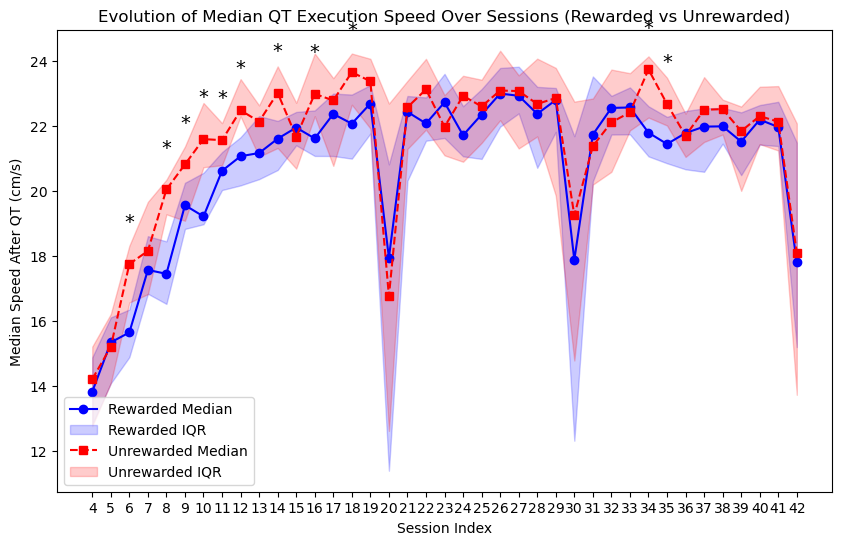

In [ ]:
# Plot evolution of QT speed depending on reward history (for all sessions)
# TODO : step by step avec profils de vitesses

index_first_session_to_plot = 4
index_last_session_to_plot = 19

rewarded_medians = []
unrewarded_medians = []
rewarded_25th_percentile = []
rewarded_75th_percentile = []
unrewarded_25th_percentile = []
unrewarded_75th_percentile = []

session_indices = sorted(median_speed_after_rewarded[list(median_speed_after_rewarded.keys())[0]].keys())
session_indices = [i for i in session_indices if index_first_session_to_plot <= i <= index_last_session_to_plot]

# Store p-values ​​for each session
p_values = []

# Number of permutations (increase for precision)
n_permutations = 10000  

# On itère sur les indices de session en utilisant uniquement ceux qui ont des données valides
for session_index in session_indices:
    rewarded_speeds = []
    unrewarded_speeds = []
    
    for mouse in mice_list:
        if session_index in median_speed_after_rewarded[mouse]:
            rewarded_speeds.append(median_speed_after_rewarded[mouse][session_index])
        if session_index in median_speed_after_unrewarded[mouse]:
            unrewarded_speeds.append(median_speed_after_unrewarded[mouse][session_index])

    # Filtrer les valeurs None avant de calculer la médiane et les quartiles
    rewarded_speeds = [speed for speed in rewarded_speeds if speed is not None]
    unrewarded_speeds = [speed for speed in unrewarded_speeds if speed is not None]

    # Calcul des médianes pour cette session uniquement si les listes ne sont pas vides
    if rewarded_speeds:
        rewarded_medians.append(np.nanmedian(rewarded_speeds))
        rewarded_25th_percentile.append(np.percentile(rewarded_speeds, 25))
        rewarded_75th_percentile.append(np.percentile(rewarded_speeds, 75))
    
    if unrewarded_speeds:
        unrewarded_medians.append(np.median(unrewarded_speeds))
        unrewarded_25th_percentile.append(np.percentile(unrewarded_speeds, 25))
        unrewarded_75th_percentile.append(np.percentile(unrewarded_speeds, 75))
    else : 
        unrewarded_medians.append(np.nan)
        unrewarded_25th_percentile.append(np.nan)
        unrewarded_75th_percentile.append(np.nan)

    # Check that we have data for both groups
    if rewarded_speeds and unrewarded_speeds:
        # Define the statistic as the difference of medians
        def median_diff(x, y):
            return np.median(x) - np.median(y)

        # Perform the permutation test
        result = permutation_test((rewarded_speeds, unrewarded_speeds), median_diff, n_resamples=n_permutations, alternative='two-sided')

        # Store the p-value
        p_values.append(result.pvalue)
    else:
        p_values.append(np.nan)  # If no data for this session

# Plotting the graph with annotated p-values
plt.figure(figsize=(10, 6))

# Rewarded curve
plt.plot(session_indices, rewarded_medians, marker='o', linestyle='-', color='blue', label='Rewarded Median')
plt.fill_between(session_indices, rewarded_25th_percentile, rewarded_75th_percentile, color='blue', alpha=0.2, label='Rewarded IQR')

# Unrewarded curve
plt.plot(session_indices, unrewarded_medians, marker='s', linestyle='--', color='red', label='Unrewarded Median')
plt.fill_between(session_indices, unrewarded_25th_percentile, unrewarded_75th_percentile, color='red', alpha=0.2, label='Unrewarded IQR')

# Add stars ​​for significant sessions (p < 0.05)
for i, (session, p) in enumerate(zip(session_indices, p_values)):
    if p < 0.05:
        y_max = max(rewarded_medians[i], unrewarded_medians[i]) + 1  # Place above the max of both groups
        plt.text(session, y_max, '*', ha='center', va='bottom', fontsize=14, color='black')

plt.xlabel('Session Index')
plt.ylabel('Median Speed After QT (cm/s)')
plt.title('Evolution of Median QT Execution Speed Over Sessions (Rewarded vs Unrewarded)')
plt.xticks(session_indices, rotation=0)  # Rotation pour lisibilité
plt.legend()
plt.show()
